Possible improvements:

- Use the crosscheck table to merge DR2 and DR3

- Check the mass: some stars do not have mass information? 


note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 408 to 218



In [109]:
from astroquery.gaia import Gaia
# Gaia.MAIN_GAIA_TABLE = "gaiadr2.gaia_source"  # Select Data Release 2
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Reselect Data Release 3, default

import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
import pandas as pd

from stellar_functions import *
from query import *
from get_stellar_info import *


In [110]:
# Query parameters
TARGET_G_MAG_LIMIT = 12  # gs.phot_g_mean_mag < TARGET_G_MAG_LIMIT
MIN_DEC = -85  # gs.dec >= MIN_DEC
MAX_DEC = 30  # gs.dec <= MAX_DEC
MIN_PARALLAX = 20  # gs.parallax >= MIN_PARALLAX (MAX_DISTANCE = 1000/MIN_PARALLAX)
SEARCH_RADIUS = 2 / 3600.0  # 2 arcseconds in degrees

directory = '../results/'


In [111]:
# import logging
# # Set the logging level for astroquery to ERROR to suppress warnings
# logging.getLogger('astroquery').setLevel(logging.ERROR)

#-------------------------------------------------------------
# Define DR2 query
#-------------------------------------------------------------
# including ap.mass_flame, ap.lum_flame, ap.radius_flame is necessary to get the astrophysical parameters 
# even though we force to use gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
# Without gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id, we would end up with the same clean merged results but without the astrophysical parameters
query_dr2 = f"""
SELECT 
    gs.source_id, 
    gs.ra, 
    gs.dec, 
    gs.phot_g_mean_mag, 
    gs.phot_bp_mean_mag, 
    gs.phot_rp_mean_mag,
    gs.parallax,
    COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs.teff_val) AS teff_val,
    COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass_flame,
    COALESCE(ap_supp.lum_flame_spec, ap.lum_flame, gs.lum_val) AS lum_flame,
    COALESCE(ap_supp.radius_flame_spec, ap.radius_flame, gs.radius_val) AS radius_flame,
    COALESCE(ap_supp.logg_gspphot_marcs, ap.logg_gspphot) AS logg_gaia,
    ap.spectraltype_esphs
FROM 
    gaiadr2.gaia_source AS gs
LEFT JOIN 
    gaiadr3.astrophysical_parameters AS ap 
    ON gs.source_id = ap.source_id
LEFT JOIN 
    gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON gs.source_id = ap_supp.source_id
WHERE 
    gs.phot_g_mean_mag < {TARGET_G_MAG_LIMIT}
    AND gs.dec BETWEEN {MIN_DEC} AND {MAX_DEC}
    AND gs.parallax >= {MIN_PARALLAX}
"""


df_dr2 = execute_gaia_query(
    query_dr2,
    str_columns = ['source_id'],
    output_file = directory + 'dr2_results.xlsx'
)
print(f"Number of stars in DR2: {len(df_dr2)}")

dr2_source_ids = tuple(df_dr2['source_id'])


#-------------------------------------------------------------
# Define the crossmatch query using the dr2_neighbourhood table
#-------------------------------------------------------------
crossmatch_query = f"""
SELECT dr2_source_id, dr3_source_id
FROM gaiadr3.dr2_neighbourhood
WHERE dr2_source_id IN {dr2_source_ids}
"""

df_crossmatch = execute_gaia_query(
    crossmatch_query,
    str_columns=['dr2_source_id', 'dr3_source_id'],
    output_file=directory + 'dr2_dr3_crossmatch.xlsx'
)
print(f"Number of stars in crossmatch: {len(df_crossmatch)}")

#-------------------------------------------------------------
# Define DR3 query
#-------------------------------------------------------------
query_dr3 = f"""
SELECT 
    gs.source_id, 
    gs.ra, 
    gs.dec, 
    gs.phot_g_mean_mag, 
    gs.phot_bp_mean_mag, 
    gs.phot_rp_mean_mag,
    gs.bp_rp, 
    gs.parallax, 
    COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs.teff_gspphot) AS teff_gspphot,
    COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass_flame,
    COALESCE(ap_supp.lum_flame_spec, ap.lum_flame) AS lum_flame,
    COALESCE(ap_supp.radius_flame_spec, ap.radius_flame) AS radius_flame,
    COALESCE(ap_supp.logg_gspphot_marcs, ap.logg_gspphot) AS logg_gaia,
    ap.spectraltype_esphs
FROM 
    gaiadr3.gaia_source AS gs
LEFT JOIN 
    gaiadr3.astrophysical_parameters AS ap 
    ON gs.source_id = ap.source_id
LEFT JOIN 
    gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON gs.source_id = ap_supp.source_id
WHERE 
    gs.phot_g_mean_mag < {TARGET_G_MAG_LIMIT}
    AND gs.dec BETWEEN {MIN_DEC} AND {MAX_DEC}
    AND gs.parallax >= {MIN_PARALLAX}
"""

df_dr3 = execute_gaia_query(
    query_dr3,
    str_columns = ['source_id'],
    output_file = directory + 'dr3_results.xlsx'
)
print(f"Number of stars in DR3: {len(df_dr3)}")

#-------------------------------------------------------------
# Merge DR2 and DR3 results 
#-------------------------------------------------------------
merged_dr2_crossmatch = pd.merge(df_dr2, df_crossmatch, left_on='source_id', right_on='dr2_source_id', how='left')
merged_results = pd.merge(merged_dr2_crossmatch, df_dr3, left_on='dr3_source_id', right_on='source_id', suffixes=('_dr2', '_dr3'), how='outer')
merged_results.to_excel(directory+'merged_results.xlsx', index=False)
adjust_column_widths(directory+'merged_results.xlsx')


Number of stars in DR2: 9463
Number of stars in crossmatch: 10053
Number of stars in DR3: 9157


In [112]:
#-------------------------------------------------------------
# Data Cleaning
#-------------------------------------------------------------

# ***** Step 1: Identify repeated dr2_source_id entries *****
non_empty_dr2 = merged_results[merged_results['dr2_source_id'].notna() & (merged_results['dr2_source_id'] != '')]
repeated_dr2_ids = non_empty_dr2[non_empty_dr2.duplicated('dr2_source_id', keep=False)]['dr2_source_id'].unique()
repeated_entries = merged_results[merged_results['dr2_source_id'].isin(repeated_dr2_ids)]

# Save repeated entries to Excel
repeated_entries.to_excel(directory + 'repeated_entries.xlsx', index=False)
adjust_column_widths(directory + 'repeated_entries.xlsx')

# ***** Step 2: Clean repeated entries *****
def check_dr3_availability(row):
    '''
    Function to check if any DR3 data is available for a given row.
    '''
    dr3_columns = [col for col in row.index if col.endswith('_dr3')]
    return not row[dr3_columns].isnull().all()

def process_repeated_group(group):
    '''
    Function to process a group of repeated entries with the same dr2_source_id.
    '''
    if len(group) != 2:
        # If there are more than 2 entries, keep only the first one
        return group.iloc[1:].index.tolist()  # Return indices of rows to remove
    
    row1, row2 = group.iloc[0], group.iloc[1]
    dr3_available1 = check_dr3_availability(row1)
    dr3_available2 = check_dr3_availability(row2)
    
    if not dr3_available1 and not dr3_available2:
        # If both rows have no DR3 data, remove the second one
        return [group.index[1]]
    elif dr3_available1 and not dr3_available2:
        # If only the first row has DR3 data, remove the second one
        return [group.index[1]]
    elif not dr3_available1 and dr3_available2:
        # If only the second row has DR3 data, remove the first one
        return [group.index[0]]
    else:
        # If both rows have DR3 data, remove the second one
        return [group.index[1]]

# Process repeated entries and get indices of rows to remove
rows_to_remove_indices = repeated_entries.groupby('dr2_source_id').apply(process_repeated_group).sum()

# Get the rows to be removed
rows_to_remove = repeated_entries.loc[rows_to_remove_indices]

# Remove the identified rows from merged_results
clean_merged_results = merged_results[~merged_results.index.isin(rows_to_remove.index)]

# Reset index of clean_merged_results
clean_merged_results = clean_merged_results.reset_index(drop=True)

# Print some information about the results
print(f"Original shape of merged_results: {merged_results.shape}")
print(f"Shape after removing duplicates: {clean_merged_results.shape}")
print(f"Number of rows removed: {merged_results.shape[0] - clean_merged_results.shape[0]}")

# Save clean_merged_results to Excel
clean_merged_results.to_excel(directory + 'clean_merged_results.xlsx', index=False)
adjust_column_widths(directory + 'clean_merged_results.xlsx')

# Save rows_to_remove to Excel
rows_to_remove.to_excel(directory + 'removed_rows.xlsx', index=False)
adjust_column_widths(directory + 'removed_rows.xlsx')

# Check if there are still any duplicates
remaining_duplicates = clean_merged_results[clean_merged_results.duplicated('dr2_source_id', keep=False)]
print(f"\nNumber of remaining duplicate dr2_source_id: {len(remaining_duplicates['dr2_source_id'].unique())}")

if not remaining_duplicates.empty:
    print("\nExample of remaining duplicates:")
    print(remaining_duplicates.groupby('dr2_source_id').first().head())
else:
    print("\nNo remaining duplicates found.")

# ***** Step 3: Consolidate the data *****
# Create a new DataFrame to store the final consolidated data
df = clean_merged_results.copy()

# Function to choose between DR3 and DR2 values
def choose_value(row, col_name):
    dr3_col = f'{col_name}_dr3'
    dr2_col = f'{col_name}_dr2'
    return row[dr3_col] if pd.notnull(row[dr3_col]) else row[dr2_col]

# List of columns to process
columns_to_process = ['ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'logg_gaia', 'spectraltype_esphs']

# Process each column
for col in columns_to_process:
    df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# Special handling for temperature
df['T_eff [K]'] = df.apply(lambda row: row['teff_gspphot'] if pd.notnull(row['teff_gspphot']) else row['teff_val'], axis=1)

# For other columns
other_columns = ['mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']
for col in other_columns:
    df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# Add bp_rp column from DR3 if available
df['bp_rp'] = df['bp_rp'].fillna(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'])

# Add the new source_id column
df['source_id'] = df['source_id_dr3'].fillna(df['source_id_dr2'])

# Update the final columns list to include the new source_id column
final_columns = ['source_id', 'source_id_dr2', 'source_id_dr3', 'ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 
                'bp_rp', 'parallax', 'T_eff [K]', 'mass_flame', 'lum_flame', 'radius_flame', 'logg_gaia', 'spectraltype_esphs']

# Create the final dataframe
df_consolidated = df[final_columns]


if 1:

    # Create a new DataFrame instead of modifying the existing one
    new_columns = ['source_id', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type']
    df_new = pd.DataFrame(columns=new_columns)

    # Populate the new DataFrame
    df_new['source_id'] = df_consolidated['source_id_dr3'].fillna(df_consolidated['source_id_dr2'])

    for index, row in df_new.iterrows():
        simbad_info = get_simbad_info_with_retry(row['source_id'])
        if simbad_info:
            df_new.loc[index, 'HD Number'] = simbad_info['HD Number']
            df_new.loc[index, 'GJ Number'] = simbad_info['GJ Number']
            df_new.loc[index, 'HIP Number'] = simbad_info['HIP Number']
            df_new.loc[index, 'Object Type'] = simbad_info['Object Type']


    # Combine the new DataFrame with the original one
    df_consolidated = pd.concat([df_consolidated, df_new[['HD Number', 'GJ Number', 'HIP Number', 'Object Type']]], axis=1)

    # Update the final columns list to include the new columns
    final_columns.extend(['HD Number', 'GJ Number', 'HIP Number', 'Object Type'])

    # Create the final dataframe with the updated column list
    df_consolidated = df_consolidated[final_columns]

    # Rename the columns
    df_consolidated = df_consolidated.rename(columns={
        'mass_flame': 'Mass [M_Sun]',
        'lum_flame': 'Luminosity [L_Sun]',
        'radius_flame': 'Radius [R_Sun]',
        'phot_g_mean_mag': 'Phot G Mean Mag',
        'phot_bp_mean_mag': 'Phot BP Mean Mag',
        'phot_rp_mean_mag': 'Phot RP Mean Mag',
        'bp_rp': 'BP-RP',
        'parallax': 'Parallax',
        'ra': 'RA',
        'dec': 'DEC',
        'spectraltype_esphs': 'Gaia Spectral type'
    })

    # Convert each column to numeric, coercing errors
    columns_to_convert = ['T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]']

    for column in columns_to_convert:
        df_consolidated[column] = pd.to_numeric(df_consolidated[column], errors='coerce')

    # Save the result to a new Excel file
    df_consolidated.to_excel(directory + 'consolidated_results.xlsx', index=False)
    adjust_column_widths(directory + 'consolidated_results.xlsx')

    # Display some statistics
    print(f"Total number of stars: {len(df_consolidated)}")
    print(f"Number of stars with DR3 source_id: {df_consolidated['source_id_dr3'].notna().sum()}")
    print(f"Number of stars with only DR2 source_id: {df_consolidated['source_id_dr3'].isna().sum()}")
    print(f"Number of stars with HD Number: {df_consolidated['HD Number'].notna().sum()}")
    print(f"Number of stars with GJ Number: {df_consolidated['GJ Number'].notna().sum()}")
    print(f"Number of stars with HIP Number: {df_consolidated['HIP Number'].notna().sum()}")


Original shape of merged_results: (10319, 29)
Shape after removing duplicates: (9727, 29)
Number of rows removed: 592

Number of remaining duplicate dr2_source_id: 1

Example of remaining duplicates:
Empty DataFrame
Columns: [source_id_dr2, ra_dr2, dec_dr2, phot_g_mean_mag_dr2, phot_bp_mean_mag_dr2, phot_rp_mean_mag_dr2, parallax_dr2, teff_val, mass_flame_dr2, lum_flame_dr2, radius_flame_dr2, logg_gaia_dr2, spectraltype_esphs_dr2, dr3_source_id, source_id_dr3, ra_dr3, dec_dr3, phot_g_mean_mag_dr3, phot_bp_mean_mag_dr3, phot_rp_mean_mag_dr3, bp_rp, parallax_dr3, teff_gspphot, mass_flame_dr3, lum_flame_dr3, radius_flame_dr3, logg_gaia_dr3, spectraltype_esphs_dr3]
Index: []

[0 rows x 28 columns]
Total number of stars: 9727
Number of stars with DR3 source_id: 9130
Number of stars with only DR2 source_id: 597
Number of stars with HD Number: 4318
Number of stars with GJ Number: 2026
Number of stars with HIP Number: 4831


In [113]:
from audio import *

if 0:
    # Display the stop button
    display(stop_button)
    # Automatically start the audio process
    start_audio_process()


Button(description='Stop Music', style=ButtonStyle())

#### HIP -- add temperature and luminosity if missing

In [114]:
len(df_consolidated)


9727

In [115]:
# Define the column specifications based on the byte positions
colspecs = [
    (39, 45),  # Num    
    (10, 15),  # Teff
    (16, 28),  # Lum
]
# Define the column names
column_names = [
    "HIP Number",
    "T_eff [K]",
    "Luminosity [L_Sun]"
]

# Read the data into a DataFrame
df_CELESTA = pd.read_fwf("../data/Catalogue_CELESTA.txt", colspecs=colspecs, names=column_names, skiprows=28)

# Display the first few rows of the DataFrame
df_CELESTA.head()

HIP Number  T_eff [K]  Luminosity [L_Sun]
0           1       6388            8.728700
1           2       4506            0.613774
2           3       8968          374.866000
3           4       7005            8.451670
4           5       5064           27.361000

In [116]:

# Step 1: Extract numeric HIP numbers from df_consolidated
df_consolidated['HIP Number'] = df_consolidated['HIP Number'].str.extract(r'HIP\s*(\d+)')
df_CELESTA['HIP Number'] = df_CELESTA['HIP Number'].astype(str)

# Step 2: Merge the dataframes on the HIP Number
merged_df = pd.merge(df_consolidated, df_CELESTA[['HIP Number', 'T_eff [K]', 'Luminosity [L_Sun]']],
                     on='HIP Number', suffixes=('', '_CELESTA'), how='left')

# Step 3: Fill missing T_eff [K] values
merged_df['T_eff [K]'] = merged_df['T_eff [K]'].fillna(merged_df['T_eff [K]_CELESTA'])

# Step 4: Fill missing Luminosity [L_Sun] values
merged_df['Luminosity [L_Sun]'] = merged_df['Luminosity [L_Sun]'].fillna(merged_df['Luminosity [L_Sun]_CELESTA'])

# Step 5: Drop the extra columns from df_CELESTA
df_consolidated_HIP = merged_df.drop(columns=['T_eff [K]_CELESTA', 'Luminosity [L_Sun]_CELESTA'])


df_consolidated_HIP.to_excel(directory + 'consolidated_HIP_results.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_HIP_results.xlsx')

df_consolidated_HIP.head()



source_id        source_id_dr2        source_id_dr3          RA  \
0  3239548631415741440  3239548631415741440  3239548631415741440   73.977490   
1  2021679765266909952  2021679765266909952  2021679765266909952  295.186714   
2  6725832095922016256  6725832095922016256  6725832095922016256  273.334712   
3  6791154257817212672  6791154257817212672  6791154257817212672  319.937189   
4  5774208531585388544  5774208531585388544                  NaN  266.588496   

         DEC  Phot G Mean Mag  Phot BP Mean Mag  Phot RP Mean Mag     BP-RP  \
0   4.670405        11.030905         12.228702          9.944361  2.284341   
1  25.596150         9.190377          9.765839          8.454739  1.311100   
2 -39.843952        11.732868         13.102717         10.575909  2.526809   
3 -26.354449         6.445514          6.742600          5.773308  0.969292   
4 -82.199938        11.296785         12.702518         10.144989  2.557529   

    Parallax  T_eff [K]  Mass [M_Sun]  Luminosity [L_Sun]  Radius [R_Sun]  \
0  27.850899        NaN           NaN                 NaN             NaN   
1  20.581957        NaN           NaN                 NaN             NaN   
2  53.199241        NaN           NaN                 NaN             NaN   
3  54.028805        NaN           NaN                 NaN             NaN   
4  31.463587  3843.6497           NaN                 NaN             NaN   

  logg_gaia Gaia Spectral type              HD Number              GJ Number  \
0                            M             HD  31412B                   None   
1                            K              HD 338736                   None   
2                            M                   None                   None   
3                            F  HD 202940, HD 202940A  GJ 825.4 A, GJ 9734 A   
4                            M                   None                   None   

  HIP Number Object Type  
0        NaN     HighPM*  
1        NaN        Star  
2        NaN     HighPM*  
3     105312         SB*  
4        NaN     HighPM*

#### HD

In [117]:
# Example usage
temperature, luminosity = get_star_properties("10700")
print("Temperature [K]:", temperature if temperature else "N/A")
print("Estimated Luminosity [L_sun]:", luminosity if luminosity else "N/A")

Temperature [K]: 5420.00849935214
Estimated Luminosity [L_sun]: 0.45289755603501747


In [118]:
# Load the stellar catalog file and store it in memory

with open('../data/Catalogue_V_117A_table1.txt', 'r') as file:
    STELLAR_CATALOG = file.readlines()

def extract_mass(hd_number):
    """
    Extract mass for a given HD number using the pre-loaded catalog.
    """
    for line in STELLAR_CATALOG:
        # Extract the HD number from the line
        line_hd_number = line[7:18].strip()
        # Check if the line contains the desired HD number
        if line_hd_number == f"HD {hd_number}":
            # Extract mass information
            mass = line[130:134].strip()
            # Return the mass as a float if available
            return float(mass) if mass else None

In [119]:

df_consolidated_HD = df_consolidated_HIP.copy()
            
from tqdm import tqdm

# Iterate over the DataFrame and fill missing values with a progress bar
for index, row in tqdm(df_consolidated_HD.iterrows(), 
                    total=df_consolidated_HD.shape[0], 
                    desc="Filling missing T_eff, Luminosity and Mass"):
    # Check for missing temperature or luminosity
    if pd.isna(row["T_eff [K]"]) or pd.isna(row["Luminosity [L_Sun]"]) or pd.isna(row["Mass [M_Sun]"]):
        # Extract and clean HD number
        hd_number = clean_hd_number(row["HD Number"])
        
        if hd_number:  # If a valid HD number was extracted
            # Retrieve properties
            temperature, luminosity = get_star_properties_with_retries(hd_number)
            mass = extract_mass(hd_number)
            
            # Fill missing values
            if pd.isna(row["T_eff [K]"]) and temperature is not None:
                df_consolidated_HD.at[index, "T_eff [K]"] = temperature
            if pd.isna(row["Luminosity [L_Sun]"]) and luminosity is not None:
                df_consolidated_HD.at[index, "Luminosity [L_Sun]"] = luminosity
            if pd.isna(row["Mass [M_Sun]"]) and mass is not None:
                df_consolidated_HD.at[index, "Mass [M_Sun]"] = mass

df_consolidated_HD.to_excel(directory + 'consolidated_HD_results.xlsx', index=False)

adjust_column_widths(directory + 'consolidated_HD_results.xlsx')

df_consolidated_HD

Filling missing T_eff, Luminosity and Mass: 100%|██████████| 9727/9727 [21:10<00:00,  7.66it/s]  


source_id        source_id_dr2        source_id_dr3  \
0     3239548631415741440  3239548631415741440  3239548631415741440   
1     2021679765266909952  2021679765266909952  2021679765266909952   
2     6725832095922016256  6725832095922016256  6725832095922016256   
3     6791154257817212672  6791154257817212672  6791154257817212672   
4     5774208531585388544  5774208531585388544                  NaN   
...                   ...                  ...                  ...   
9722  1843877121426321920                  NaN  1843877121426321920   
9723  6255498752849053568                  NaN  6255498752849053568   
9724  1168984617870183808                  NaN  1168984617870183808   
9725  1179916752747453952                  NaN  1179916752747453952   
9726  1186325496788069632                  NaN  1186325496788069632   

              RA        DEC  Phot G Mean Mag  Phot BP Mean Mag  \
0      73.977490   4.670405        11.030905         12.228702   
1     295.186714  25.596150         9.190377          9.765839   
2     273.334712 -39.843952        11.732868         13.102717   
3     319.937189 -26.354449         6.445514          6.742600   
4     266.588496 -82.199938        11.296785         12.702518   
...          ...        ...              ...               ...   
9722  312.443943  25.770898         7.541234          7.828997   
9723  233.486201 -17.003618         8.110476          8.336336   
9724  229.674296  10.427684         7.020629          7.260996   
9725  219.560369  14.028250         8.088094          8.439837   
9726  223.347180  15.705250         6.699353          6.643613   

      Phot RP Mean Mag     BP-RP   Parallax    T_eff [K]  Mass [M_Sun]  \
0             9.944361  2.284341  27.850899  6011.737982           NaN   
1             8.454739  1.311100  20.581957          NaN           NaN   
2            10.575909  2.526809  53.199241          NaN           NaN   
3             5.773308  0.969292  54.028805  5395.107623           NaN   
4            10.144989  2.557529  31.463587  3843.649700           NaN   
...                ...       ...        ...          ...           ...   
9722          7.083800  0.745197  20.878916  5902.499000      1.043211   
9723          7.298113  1.038223  26.336754  5046.613774           NaN   
9724          6.612955  0.648041  20.736023  5700.000000      1.209424   
9725          7.556296  0.883541  20.353960  5622.000000      0.909394   
9726          5.897090  0.746523  20.761326          NaN           NaN   

      Luminosity [L_Sun]  Radius [R_Sun] logg_gaia Gaia Spectral type  \
0               1.721869             NaN                            M   
1                    NaN             NaN                            K   
2                    NaN             NaN                            M   
3               0.704693             NaN                            F   
4                    NaN             NaN                            M   
...                  ...             ...       ...                ...   
9722            1.606335        1.211894    4.2699                  F   
9723            0.679204             NaN                            F   
9724            2.642376        1.358928                                
9725            1.092664        1.148828                            G   
9726                 NaN             NaN                            F   

                  HD Number              GJ Number HIP Number Object Type  
0                HD  31412B                   None        NaN     HighPM*  
1                 HD 338736                   None        NaN        Star  
2                      None                   None        NaN     HighPM*  
3     HD 202940, HD 202940A  GJ 825.4 A, GJ 9734 A     105312         SB*  
4                      None                   None        NaN     HighPM*  
...                     ...                    ...        ...         ...  
9722              HD 198483                   None     102815     HighPM

In [120]:
if 0: # parallel 
    from multiprocessing import Pool
    from functools import partial

    def process_row(row, df):
        """Process a single row and return the updated values"""
        if pd.isna(row["T_eff [K]"]) or pd.isna(row["Luminosity [L_Sun]"]) or pd.isna(row["Mass [M_Sun]"]):
            hd_number = clean_hd_number(row["HD Number"])
            
            if hd_number:
                temperature, luminosity = get_star_properties_with_retries(hd_number)
                mass = extract_mass(hd_number)
                
                # Return updated values
                return {
                    'index': row.name,
                    'T_eff [K]': temperature if pd.isna(row["T_eff [K]"]) else row["T_eff [K]"],
                    'Luminosity [L_Sun]': luminosity if pd.isna(row["Luminosity [L_Sun]"]) else row["Luminosity [L_Sun]"],
                    'Mass [M_Sun]': mass if pd.isna(row["Mass [M_Sun]"]) else row["Mass [M_Sun]"]
                }
        
        # Return original values if no updates needed
        return {
            'index': row.name,
            'T_eff [K]': row["T_eff [K]"],
            'Luminosity [L_Sun]': row["Luminosity [L_Sun]"],
            'Mass [M_Sun]': row["Mass [M_Sun]"]
        }

    def parallel_process_dataframe(df):
        df_consolidated_HD = df.copy()
        
        # Create a pool of workers
        with Pool() as pool:
            # Process rows in parallel with progress bar
            results = list(tqdm(
                pool.imap(partial(process_row, df=df_consolidated_HD), 
                [row for _, row in df_consolidated_HD.iterrows()]),
                total=len(df_consolidated_HD),
                desc="Processing rows in parallel"
            ))
        
        # Update DataFrame with results
        for result in results:
            idx = result['index']
            df_consolidated_HD.at[idx, 'T_eff [K]'] = result['T_eff [K]']
            df_consolidated_HD.at[idx, 'Luminosity [L_Sun]'] = result['Luminosity [L_Sun]']
            df_consolidated_HD.at[idx, 'Mass [M_Sun]'] = result['Mass [M_Sun]']
        
        return df_consolidated_HD

    # Use the parallel processing function
    df_consolidated_HD = parallel_process_dataframe(df_consolidated_HIP)

    # Save results
    df_consolidated_HD.to_excel(directory + 'consolidated_HD_results.xlsx', index=False)
    adjust_column_widths(directory + 'consolidated_HD_results.xlsx')

#### Simbad

In [121]:
len(df_consolidated_HD)

9727

In [122]:
# Example usage
if 1:
    gaia_dr3_id = "4072260704719970944"
    original, processed = get_stellar_type_dr3(gaia_dr3_id)
    print(f"Original: {original}, Processed: {processed}")

# Example usage for DR2
if 0:
    # gaia_dr2_id = "1234567890123456789"
    gaia_dr2_id = "25488745411919360"
    original, processed = get_stellar_type_dr2(gaia_dr2_id)
    print(f"Original: {original}, Processed: {processed}")
# 


Original: K8Vk, Processed: K8V


In [123]:
if 0:
    df_consolidated_HD = pd.read_excel(directory + 'consolidated_HD_results.xlsx', dtype={'source_id': str, 'source_id_dr2': str, 'source_id_dr3': str, 'HIP Number': str})
    df_consolidated_HD

In [124]:
list(df_consolidated_HD.columns)

['source_id',
 'source_id_dr2',
 'source_id_dr3',
 'RA',
 'DEC',
 'Phot G Mean Mag',
 'Phot BP Mean Mag',
 'Phot RP Mean Mag',
 'BP-RP',
 'Parallax',
 'T_eff [K]',
 'Mass [M_Sun]',
 'Luminosity [L_Sun]',
 'Radius [R_Sun]',
 'logg_gaia',
 'Gaia Spectral type',
 'HD Number',
 'GJ Number',
 'HIP Number',
 'Object Type']

In [125]:
# Update the DataFrame with stellar properties 
df_consolidated_simbad = get_stellar_properties_from_gaia(df_consolidated_HD)

# Save to Excel
filename = directory + 'consolidated_Simbad_results.xlsx'
df_consolidated_simbad.to_excel(filename, index=False)
adjust_column_widths(filename)


0 3239548631415741440 M2.0V M2V
1 2021679765266909952 K3V K3V
2 6725832095922016256  None
3 6791154257817212672 G7V G7V
4 5774208531585388544 M4e M4
-- No data found for stellar type (2) M4.
7 4531962186952439808 K7Ve K7V
11 635690447259492352  None
12 2950189709661242112  None
13 5266270443442455040 K4Ve K4V
14 4221163269481517312 K5 K5
-- No data found for stellar type (2) K5.
17 3558078971047964800 K5V K5V
18 3558078936688219776 K7V K7V
20 3341002562175024640  None
21 3343573598320013440 M2.5Ve M2.5V
M2V M3V
22 76859028173079424 K6V K6V
24 76868614540049408 M4.5V M4.5V
M4V M5V
26 6060127150214449408 K4V(e) K4V
27 4375233191015944192 K7V K7V
No data found for Gaia DR3 ID 4968625464611495424.
32 4968625464611495424 None None
33 5914455775207048704 K0.5V K0.5V
K0V K1V
36 5885471411757745408 M4 M4
-- No data found for stellar type (2) M4.
37 6336799631897368960 K7 K7
-- No data found for stellar type (2) K7.
38 6326750233058362880 dM4.5e None
39 2928593411513649920  None
45 426993238260

In [126]:
if 0:
    df_consolidated_simbad = pd.read_excel(directory + 'consolidated_Simbad_results.xlsx', dtype={'source_id': str, 'source_id_dr2': str, 'source_id_dr3': str, 'HIP Number': str})
    df_consolidated_simbad

In [127]:
len(df_consolidated_simbad) 

9727

In [128]:
df_consolidated = df_consolidated_simbad.copy()

df_consolidated['Density [Solar unit]'] = None
df_consolidated.loc[df_consolidated['Mass [M_Sun]'].notna() & df_consolidated['Radius [R_Sun]'].notna(), 'Density [Solar unit]'] = df_consolidated['Mass [M_Sun]'] / (df_consolidated['Radius [R_Sun]'] ** 3)

# Reorder columns to place 'Density [Solar unit]' after 'Radius [R_Sun]'
cols = df_consolidated.columns.tolist()
density_index = cols.index('Density [Solar unit]')
radius_index = cols.index('Radius [R_Sun]')
cols.insert(radius_index + 1, cols.pop(density_index))
df_consolidated = df_consolidated[cols]

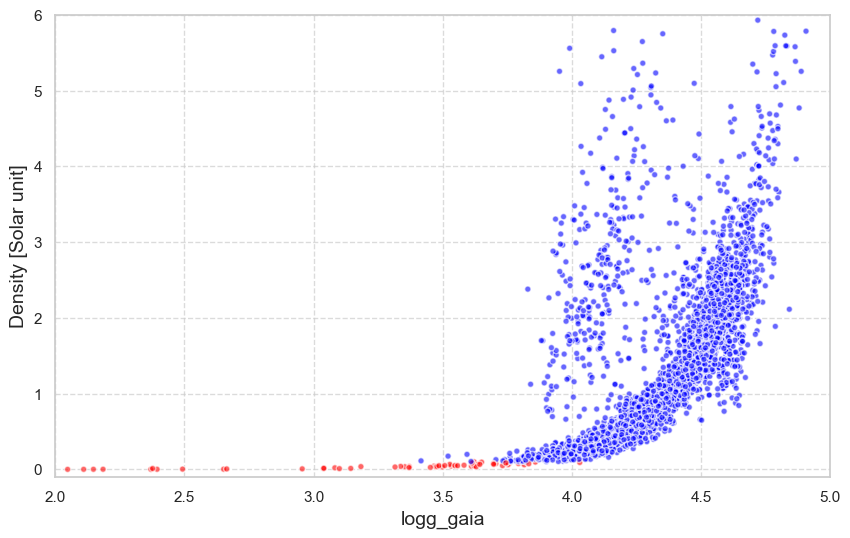

In [173]:
df_consolidated['logg_gaia'] = pd.to_numeric(df_consolidated['logg_gaia'], errors='coerce')

plt.figure(figsize=(10, 6))

colors = np.where(df_consolidated['Density [Solar unit]'] < 0.1, 'red', 'blue')

plt.scatter(df_consolidated['logg_gaia'], df_consolidated['Density [Solar unit]'], alpha=0.6, edgecolors='w', s=20, c=colors)
plt.xlabel('logg_gaia', fontsize=14)
plt.ylabel('Density [Solar unit]', fontsize=14)
plt.ylim(-0.1, 6)
plt.xlim(2, 5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [170]:
# len()
df_consolidated['logg_gaia']

0             
1             
2             
3             
4             
         ...  
9722    4.2699
9723          
9724          
9725          
9726          
Name: logg_gaia, Length: 9727, dtype: object

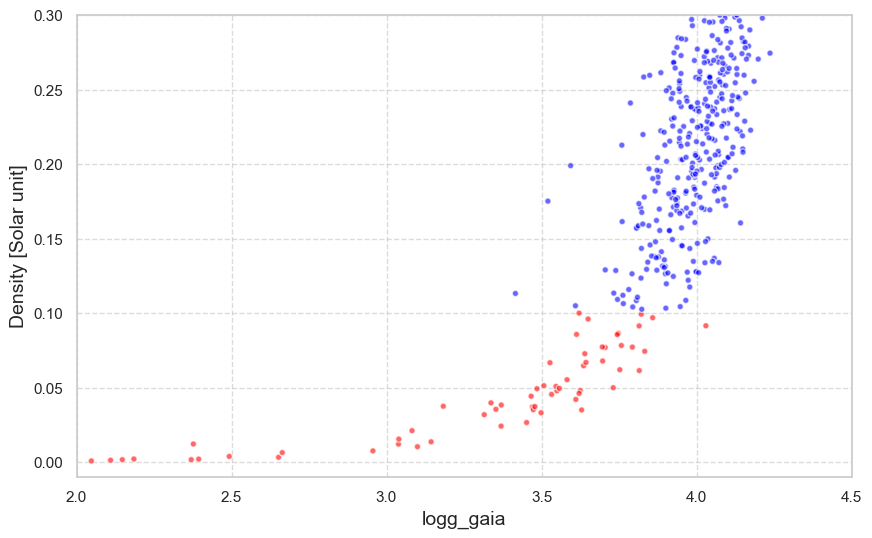

In [174]:
plt.figure(figsize=(10, 6))

colors = np.where(df_consolidated['Density [Solar unit]'] < 0.1, 'red', 'blue')

plt.scatter(df_consolidated['logg_gaia'], df_consolidated['Density [Solar unit]'], alpha=0.6, edgecolors='w', s=20, c=colors)
plt.xlabel('logg_gaia', fontsize=14)
plt.ylabel('Density [Solar unit]', fontsize=14)
plt.ylim(-0.01, 0.3)
plt.xlim(2, 4.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [175]:
#-------------------------------------------------------------
# Extract data with mass and luminosity information available
#-------------------------------------------------------------
df_filtered = df_consolidated.copy()

# Filter out stars with missing mass or luminosity information
df_filtered = df_filtered[(df_filtered['Luminosity [L_Sun]'].notna()) & (df_filtered['T_eff [K]'].notna())]

print('Number of stars with both T_eff and Luminosity available:', len(df_filtered))

# Check for non-empty rows in the specified columns
non_empty_rows = df_consolidated[
    df_consolidated['Luminosity [L_Sun]'].notna() &
    df_consolidated['Radius [R_Sun]'].notna() &
    df_consolidated['T_eff [K]'].notna() &
    df_consolidated['Mass [M_Sun]'].notna()
]

# Count the number of such rows
num_non_empty_rows = len(non_empty_rows)

print(f"Number of stars with all of 'Luminosity [L_Sun]', 'T_eff [K]', 'Mass [M_Sun]' and 'Radius [R_Sun]' available: {num_non_empty_rows}")

# Filter out stars with temperature < 3500K or > 7000K
df_filtered = df_filtered[
    (df_filtered['T_eff [K]'] >= 3800) & 
    (df_filtered['T_eff [K]'] <= 7000)
]
# Filter out stars with luminosity < 0.01 or > 4 L_Sun
df_filtered = df_filtered[
    (df_filtered['Luminosity [L_Sun]'] < 5.2) & # 5--> 5.2, to include HD23754 (F5IV-V)
    (df_filtered['Luminosity [L_Sun]'] > 0.05)
]
# df_filtered = df_filtered[df_filtered['Radius [R_Sun]'] < 2] #--> redundant 

# Filter out stars with density < 0.5 or > 5 solor unit
if 1:
    df_filtered = df_filtered[
        ((df_filtered['Density [Solar unit]'] >= 0.1) & 
            (df_filtered['Density [Solar unit]'] < 5)) |
        df_filtered['Radius [R_Sun]'].isna()
    ]

# Filter out stars with logg < 3.9 (i.e. sub-giants / giants)    
df_filtered['logg_gaia'] = pd.to_numeric(df_filtered['logg_gaia'], errors='coerce')
df_filtered = df_filtered[
    (df_filtered['logg_gaia'] > 3.8) | 
    (df_filtered['logg_gaia'].isna())
]

# Save the filtered consolidated data to a new Excel file
df_filtered.to_excel(directory + 'consolidated_results_kept.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_results_kept.xlsx')
display(df_filtered)

Number of stars with both T_eff and Luminosity available: 7435
Number of stars with all of 'Luminosity [L_Sun]', 'T_eff [K]', 'Mass [M_Sun]' and 'Radius [R_Sun]' available: 6526


source_id        source_id_dr2        source_id_dr3  \
0     3239548631415741440  3239548631415741440  3239548631415741440   
1     2021679765266909952  2021679765266909952  2021679765266909952   
3     6791154257817212672  6791154257817212672  6791154257817212672   
5     5774205537990380160  5774205537990380160  5774205537990380160   
6     6350283492745097728  6350283492745097728  6350283492745097728   
...                   ...                  ...                  ...   
9719  2924599091919101568                  NaN  2924599091919101568   
9722  1843877121426321920                  NaN  1843877121426321920   
9723  6255498752849053568                  NaN  6255498752849053568   
9724  1168984617870183808                  NaN  1168984617870183808   
9725  1179916752747453952                  NaN  1179916752747453952   

              RA        DEC  Phot G Mean Mag  Phot BP Mean Mag  \
0      73.977490   4.670405        11.030905         12.228702   
1     295.186714  25.596150         9.190377          9.765839   
3     319.937189 -26.354449         6.445514          6.742600   
5     266.926570 -82.217355         8.710826          9.220657   
6     355.984635 -82.508908         7.540228          7.845232   
...          ...        ...              ...               ...   
9719   98.126279 -24.124086         9.420027          9.898773   
9722  312.443943  25.770898         7.541234          7.828997   
9723  233.486201 -17.003618         8.110476          8.336336   
9724  229.674296  10.427684         7.020629          7.260996   
9725  219.560369  14.028250         8.088094          8.439837   

      Phot RP Mean Mag     BP-RP   Parallax  ...  Density [Solar unit]  \
0             9.944361  2.284341  27.850899  ...              4.959617   
1             8.454739  1.311100  20.581957  ...              1.812399   
3             5.773308  0.969292  54.028805  ...              1.192571   
5             8.044305  1.176353  32.132453  ...              1.793215   
6             7.064041  0.781191  25.065155  ...              1.049608   
...                ...       ...        ...  ...                   ...   
9719          8.779751  1.119022  20.280825  ...              1.452893   
9722          7.083800  0.745197  20.878916  ...              0.586108   
9723          7.298113  1.038223  26.336754  ...              1.450092   
9724          6.612955  0.648041  20.736023  ...              0.481935   
9725          7.556296  0.883541  20.353960  ...              0.599772   

      logg_gaia  Gaia Spectral type              HD Number  \
0           NaN                   M             HD  31412B   
1           NaN                   K              HD 338736   
3           NaN                   F  HD 202940, HD 202940A   
5        4.5664                   K              HD 158866   
6        4.3757                   G              HD 222669   
...         ...                 ...                    ...   
9719     4.5107                   K                   None   
9722     4.2699                   F              HD 198483   
9723        NaN                   F              HD 138648   
9724        NaN                      HD 136160, HD 136160A   
9725        NaN                   G              HD 128731   

                  GJ Number  HIP Number Object Type Stellar Parameter Source  \
0                      None         NaN     HighPM*       SIMBAD + empirical   
1                      None         NaN        Star       SIMBAD + empirical   
3     GJ 825.4 A, GJ 9734 A      105312         SB*       SIMBAD + empirical   
5                      None       87091     HighPM*                     GAIA   
6                      None      117066     HighPM*                     GAIA   
...                     ...         ...         ...                      ...   
9719                   None         NaN         SB*                     GAIA   
9722                   None      102815     HighPM*                     GAIA   
9723            

In [176]:
# Find entries that were removed during filtering
df_removed = df_consolidated[~df_consolidated['source_id'].isin(df_filtered['source_id'])]

# Save the removed entries to Excel
output_path = directory + 'consolidated_results_removed.xlsx'
df_removed.to_excel(output_path, index=False)
adjust_column_widths(output_path)

# Print some statistics
print(f"Total entries in df_consolidated: {len(df_consolidated)}")
print(f"Entries kept in df_filtered: {len(df_filtered)}")
print(f"Entries removed and saved to file: {len(df_removed)}")

Total entries in df_consolidated: 9727
Entries kept in df_filtered: 5024
Entries removed and saved to file: 4703


In [133]:
combined_df = df_filtered.copy()

In [134]:
len(combined_df)

5024

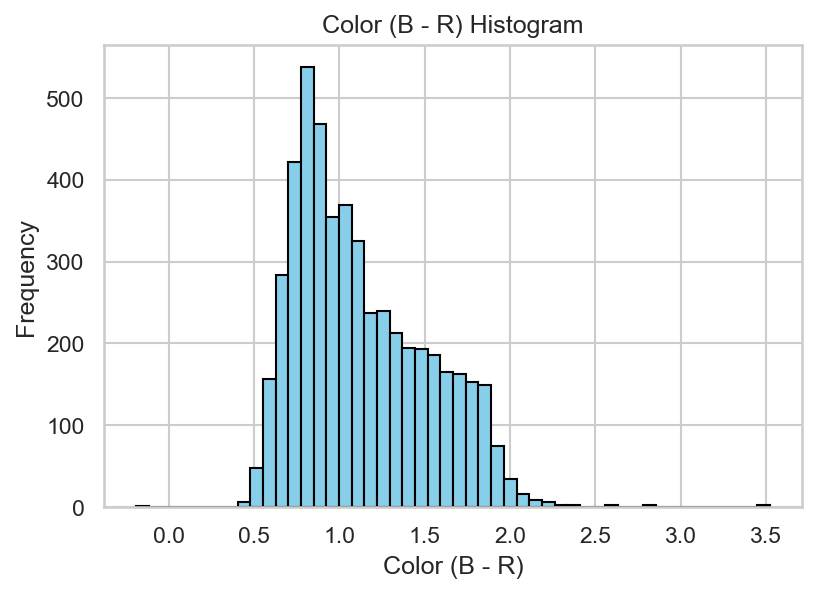

In [135]:
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']


# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution
plt.hist(color, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Color (B - R)')
plt.ylabel('Frequency')
plt.title('Color (B - R) Histogram')
plt.savefig('../figures/color_histogram.png', dpi=300)  # Save the plot as a PNG file
plt.show()

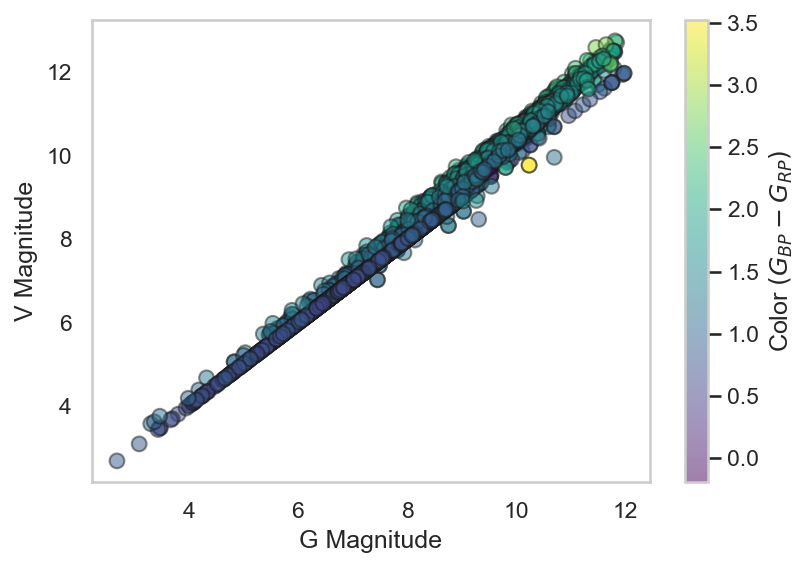

In [136]:

# Assuming 'color' is a column in combined_df or an array of the same length as the DataFrame
# For example, if 'color' is the difference between 'Phot BP Mean Mag' and 'Phot RP Mean Mag'
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']

# Calculate the conversion factor for colors between 1 and 4
conv = 0.20220 + 0.02489 * color

# Use np.where to apply the conversion conditionally
V_mag = np.where((color >= 1) & (color <= 4),
                 combined_df['Phot BP Mean Mag'] - conv,
                 combined_df['Phot G Mean Mag'])

# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution

# Plot the diagram using the color array for point colors
plt.scatter(combined_df['Phot G Mean Mag'], V_mag, c=color, cmap='viridis', edgecolor='k', s=50, alpha=0.5)
plt.xlabel('G Magnitude')
plt.ylabel('V Magnitude')
# plt.title('Color-Magnitude Diagram')
plt.colorbar(label='Color $(G_{BP} - G_{RP})$')
plt.grid()
plt.savefig('../figures/color_magnitude_diagram.png', dpi=300)
plt.show()


In [137]:
# List of columns to convert to numeric
columns_to_convert = ['T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]']

# Convert specified columns to numeric, coercing errors to NaN
for column in columns_to_convert:
    combined_df[column] = pd.to_numeric(combined_df[column], errors='coerce')

# Display the first few rows to verify the conversion
display(combined_df.head())

source_id        source_id_dr2        source_id_dr3          RA  \
0  3239548631415741440  3239548631415741440  3239548631415741440   73.977490   
1  2021679765266909952  2021679765266909952  2021679765266909952  295.186714   
3  6791154257817212672  6791154257817212672  6791154257817212672  319.937189   
5  5774205537990380160  5774205537990380160  5774205537990380160  266.926570   
6  6350283492745097728  6350283492745097728  6350283492745097728  355.984635   

         DEC  Phot G Mean Mag  Phot BP Mean Mag  Phot RP Mean Mag     BP-RP  \
0   4.670405        11.030905         12.228702          9.944361  2.284341   
1  25.596150         9.190377          9.765839          8.454739  1.311100   
3 -26.354449         6.445514          6.742600          5.773308  0.969292   
5 -82.217355         8.710826          9.220657          8.044305  1.176353   
6 -82.508908         7.540228          7.845232          7.064041  0.781191   

    Parallax  ...  Density [Solar unit]  logg_gaia  Gaia Spectral type  \
0  27.850899  ...              4.959617        NaN                   M   
1  20.581957  ...              1.812399        NaN                   K   
3  54.028805  ...              1.192571        NaN                   F   
5  32.132453  ...              1.793215     4.5664                   K   
6  25.065155  ...              1.049608     4.3757                   G   

               HD Number              GJ Number  HIP Number Object Type  \
0             HD  31412B                   None         NaN     HighPM*   
1              HD 338736                   None         NaN        Star   
3  HD 202940, HD 202940A  GJ 825.4 A, GJ 9734 A      105312         SB*   
5              HD 158866                   None       87091     HighPM*   
6              HD 222669                   None      117066     HighPM*   

  Stellar Parameter Source SIMBAD Spectral Type Readable Spectral Type  
0       SIMBAD + empirical                M2.0V                    M2V  
1       SIMBAD + empirical                  K3V                    K3V  
3       SIMBAD + empirical                  G7V                    G7V  
5                     GAIA                 None                   None  
6                     GAIA                 None                   None  

[5 rows x 24 columns]

In [140]:
# Insert the 'V_mag' column right after the 'DEC' column
if 'V_mag' not in combined_df.columns:
    combined_df.insert(combined_df.columns.get_loc('DEC') + 1, 'V_mag', V_mag)

if 'T_eff [K]' in combined_df.columns:

    # Calculate the HZ_limit
    hz_limits = combined_df.apply(lambda row: calculate_habitable_zone(row['T_eff [K]'], row['Luminosity [L_Sun]']), axis=1)

    if 'HZ_limit [AU]' not in combined_df.columns:
        # Find the index of the 'Radius [R_Sun]' column
        radius_index = combined_df.columns.get_loc('Radius [R_Sun]')
        # Insert the new column after 'Radius [R_Sun]'        
        combined_df.insert(radius_index + 1, 'HZ_limit [AU]', hz_limits)
    # Sort the DataFrame by temperature (Teff)
    combined_df = combined_df.sort_values('T_eff [K]')    

# Export the combined DataFrame to an Excel file
combined_excel_file = 'combined_query.xlsx'
output_path = directory + combined_excel_file
combined_df.to_excel(output_path, index=False)

print(f"Combined results saved to {output_path}")
display(combined_df.head())

# Adjust the column widths
adjust_column_widths(output_path)

Combined results saved to ../results/combined_query.xlsx


source_id        source_id_dr2        source_id_dr3  \
6072  4230094705509739904  4230094705509739904  4230094705509739904   
7974  4009947704255866752  4009947704255866752  4009947704255866752   
2476  3836586468953204608  3836586468953204608  3836586468953204608   
7610  4161254832282736384  4161254832282736384  4161254832282736384   
8319  2541200830419126016  2541200830419126016  2541200830419126016   

              RA        DEC      V_mag  Phot G Mean Mag  Phot BP Mean Mag  \
6072  304.689898  -0.657608  10.990482        10.256057         11.241716   
7974  185.893947  27.913777  11.278345        10.616134         11.526615   
2476  151.736626   2.963959   9.925537         9.332266         10.171158   
7610  275.952331  -5.152040  11.137876        10.448272         11.387362   
8319    4.801529  -3.054584  10.891651        10.280761         11.137734   

      Phot RP Mean Mag     BP-RP  ...  Density [Solar unit]  logg_gaia  \
6072          9.271683  1.970034  ...              2.803773        NaN   
7974          9.675657  1.850958  ...              2.381466        NaN   
2476          8.426665  1.744493  ...              1.486364     4.4182   
7610          9.487524  1.899838  ...               2.64004     4.7173   
8319          9.374646  1.763088  ...              2.153408     4.4921   

      Gaia Spectral type  HD Number          GJ Number  HIP Number  \
6072                   M       None               None      100133   
7974                   M       None               None       60448   
2476                   K       None  GJ 9313, GJ 378.2       49544   
7610                   M       None               None       90147   
8319                   K       None               None        1539   

     Object Type  Stellar Parameter Source SIMBAD Spectral Type  \
6072     HighPM*        SIMBAD + empirical                  M0V   
7974     HighPM*                      GAIA                 None   
2476     HighPM*                      GAIA                 None   
7610     HighPM*                      GAIA                 None   
8319     HighPM*        SIMBAD + empirical                  K5V   

     Readable Spectral Type  
6072                    M0V  
7974                   None  
2476                   None  
7610                   None  
8319                    K5V  

[5 rows x 26 columns]

In [141]:
from rv_prec import calculate_rv_precision

rv_precisions = []

for i in range(len(combined_df)):
    result, rv_precision = calculate_rv_precision(Temp=combined_df.iloc[i]['T_eff [K]'], Vmag=combined_df.iloc[i]['V_mag'])

    rv_precisions.append(rv_precision)

In [142]:
# Find the index of 'HZ_limit [AU]' column
hz_limit_index = combined_df.columns.get_loc('HZ_limit [AU]')

# Insert the rv_precisions to the right of 'HZ_limit [AU]'
combined_df.insert(hz_limit_index + 1, 'RV precision [m/s]', rv_precisions)

In [143]:
merged_df = combined_df.copy()

merged_df = merged_df[merged_df['Object Type'] != 'WhiteDwarf']
# Save the updated Excel file
output_path = directory + 'combined_query_with_RV_precision.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

### Calculate the HZ mass detection limit

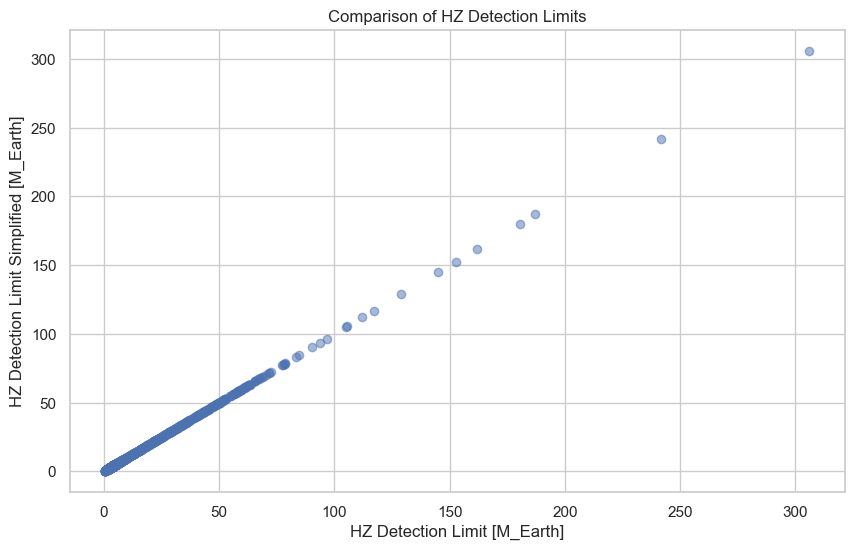

In [144]:
# Calculate detection limits using both methods
merged_df['HZ Detection Limit [M_Earth]'] = merged_df.apply(
    lambda row: calculate_hz_detection_limit(
        row['RV precision [m/s]'],
        row['Mass [M_Sun]'],
        row['HZ_limit [AU]']
    ),
    axis=1
)

merged_df['HZ Detection Limit Simplified [M_Earth]'] = merged_df.apply(
    lambda row: calculate_hz_detection_limit_simplify(
        row['RV precision [m/s]'],
        row['Mass [M_Sun]'],
        row['HZ_limit [AU]']
    ),
    axis=1
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['HZ Detection Limit [M_Earth]'], merged_df['HZ Detection Limit Simplified [M_Earth]'], alpha=0.5)
# plt.plot([0, max(merged_df['HZ Detection Limit [M_Earth]'])], [0, max(merged_df['HZ Detection Limit [M_Earth]'])], 'r--')
plt.xlabel('HZ Detection Limit [M_Earth]')
plt.ylabel('HZ Detection Limit Simplified [M_Earth]')
plt.title('Comparison of HZ Detection Limits')
plt.grid(True)
plt.show()



In [145]:
# Apply the calculation to each row
merged_df['HZ Detection Limit [M_Earth]'] = merged_df.apply(
    lambda row: calculate_hz_detection_limit(
        row['RV precision [m/s]'],
        row['Mass [M_Sun]'],
        row['HZ_limit [AU]']
    ),
    axis=1
)

# Print some statistics about the new column
print(merged_df['HZ Detection Limit [M_Earth]'].describe())

# Count and print the number of NaN values
nan_count = merged_df['HZ Detection Limit [M_Earth]'].isna().sum()
print(f"Number of NaN values: {nan_count}")

# Reorder the columns to place the new column next to 'Mass'
cols = merged_df.columns.tolist()
mass_index = cols.index('RV precision [m/s]')
cols.insert(mass_index + 1, cols.pop(cols.index('HZ Detection Limit [M_Earth]')))
merged_df = merged_df[cols]

# Save the updated DataFrame
output_path = directory + 'combined_query_with_mass_detection_limit.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

print(f"Updated DataFrame saved to '{output_path}'.")


count    4932.000000
mean        6.760313
std        12.619931
min         0.291567
25%         3.054057
50%         3.911261
75%         4.938754
max       306.121913
Name: HZ Detection Limit [M_Earth], dtype: float64
Number of NaN values: 91
Updated DataFrame saved to '../results/combined_query_with_mass_detection_limit.xlsx'.


In [146]:
len(merged_df[merged_df['HZ Detection Limit [M_Earth]'] < 4])

2613

In [147]:
if 0:
    merged_df = pd.read_excel('../results/combined_query_with_mass_detection_limit.xlsx', dtype={'source_id': str, 'source_id_dr2': str, 'source_id_dr3': str, 'HIP Number': str})

In [148]:
len(merged_df)

5023

### Background stars removal

In [149]:
# ---------------------------------------------------------------
# Batch query for Gaia DR2/DR3 in parallel with progress tracking
# ---------------------------------------------------------------
import pandas as pd
from astroquery.gaia import Gaia
import time
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm  # Import tqdm for progress tracking

# Function to create a query for nearby stars
def create_neighbor_query(source_id, ra, dec, neighbor_g_mag_limit, search_radius, data_release):
    query = f"""
    SELECT 
        source_id, ra, dec, phot_g_mean_mag
    FROM 
        {data_release}.gaia_source
    WHERE 
        1=CONTAINS(
            POINT('ICRS', {ra}, {dec}),
            CIRCLE('ICRS', ra, dec, {search_radius})
        )
        AND phot_g_mean_mag < {neighbor_g_mag_limit}
        AND source_id != {source_id}
    """
    return query

# Function to process each row with retry logic
def process_row_with_retry(row, max_retries=3, delay=5):
    attempt = 0
    while attempt < max_retries:
        try:
            if not pd.isna(row['source_id_dr3']):
                query = create_neighbor_query(
                    source_id=row['source_id_dr3'],
                    ra=row['RA'],
                    dec=row['DEC'],
                    neighbor_g_mag_limit=row['Phot G Mean Mag']+3,
                    search_radius=SEARCH_RADIUS,
                    data_release='gaiadr3'
                )
            else:
                query = create_neighbor_query(
                    source_id=row['source_id_dr2'],
                    ra=row['RA'],
                    dec=row['DEC'],
                    neighbor_g_mag_limit=row['Phot G Mean Mag']+3,
                    search_radius=SEARCH_RADIUS,
                    data_release='gaiadr2'
                )
            
            # Execute the query
            neighbors_df = execute_gaia_query(query)
            
            # Check if bright neighbors exist
            if neighbors_df is not None and not neighbors_df.empty:
                return (row, True)
            else:
                return (row, False)
        except Exception as e:
            print(f"An error occurred: {e}")
            attempt += 1
            if attempt < max_retries:
                print(f"Retrying in {delay} seconds... (Attempt {attempt}/{max_retries})")
                time.sleep(delay)
            else:
                print("Max retries reached. Skipping this row.")
                return (row, False)

# DataFrames: merged_df (input sources)
rows_with_bright_neighbors = []
rows_without_bright_neighbors = []

# Use ThreadPoolExecutor to process rows in parallel with progress tracking
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_row_with_retry, [row for idx, row in merged_df.iterrows()]), total=len(merged_df), desc="Processing rows"))
    for row, has_bright_neighbors in results:
        if has_bright_neighbors:
            rows_with_bright_neighbors.append(row)
        else:
            rows_without_bright_neighbors.append(row)

# Create DataFrames for rows with and without bright neighbors
bright_neighbors_df = pd.DataFrame(rows_with_bright_neighbors)
rows_without_bright_neighbors_df = pd.DataFrame(rows_without_bright_neighbors)

Processing rows:  14%|█▎        | 686/5023 [00:36<02:40, 27.09it/s]

An error occurred: [Errno 8] nodename nor servname provided, or not known
Retrying in 5 seconds... (Attempt 1/3)


Processing rows:  40%|████      | 2028/5023 [01:35<02:10, 22.89it/s]

An error occurred: [Errno 8] nodename nor servname provided, or not known
Retrying in 5 seconds... (Attempt 1/3)


Processing rows: 100%|██████████| 5023/5023 [03:47<00:00, 22.08it/s]


In [150]:
print(f"Stars with bright neighbors: {len(bright_neighbors_df)}")
output_path = directory + 'stars_with_bright_neighbors.xlsx'
bright_neighbors_df.to_excel(output_path, index=False)
adjust_column_widths(output_path)

print(f"Stars without bright neighbors: {len(rows_without_bright_neighbors_df)}")
output_path = directory + 'stars_without_bright_neighbors.xlsx'
rows_without_bright_neighbors_df.to_excel(output_path, index=False)
adjust_column_widths(output_path)

Stars with bright neighbors: 114
Stars without bright neighbors: 4909


In [151]:
merged_df = rows_without_bright_neighbors_df.copy()

### Statistics and plots

In [152]:
print(merged_df.columns.tolist())

['source_id', 'source_id_dr2', 'source_id_dr3', 'RA', 'DEC', 'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag', 'BP-RP', 'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 'RV precision [m/s]', 'HZ Detection Limit [M_Earth]', 'Density [Solar unit]', 'logg_gaia', 'Gaia Spectral type', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type', 'Stellar Parameter Source', 'SIMBAD Spectral Type', 'Readable Spectral Type', 'HZ Detection Limit Simplified [M_Earth]']


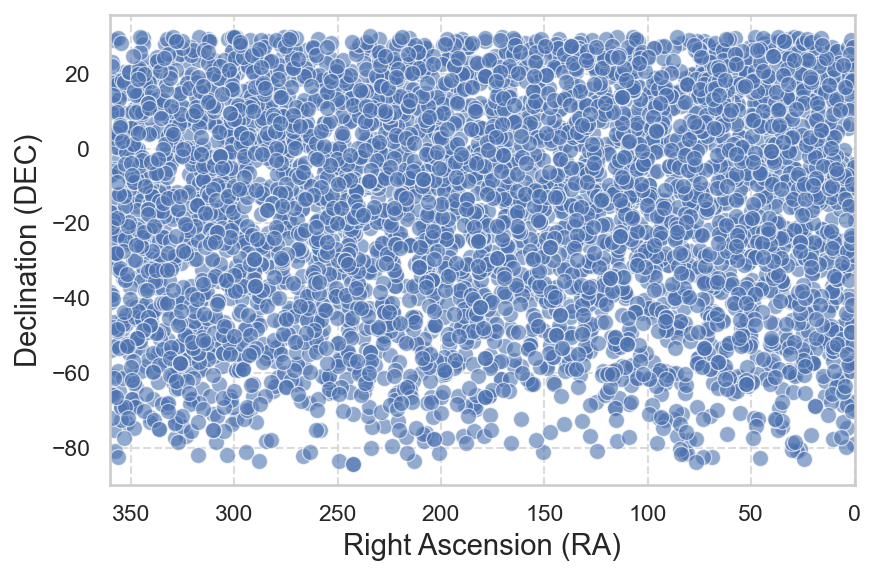

In [153]:
import seaborn as sns

def plot_scatter(x, y, data, xlabel, ylabel, xlim=None, ylim=None, filename=None, color=None, alpha=0.7, size=60, invert_xaxis=False, x2=None, y2=None, data2=None, color2=None, alpha2=0.7, size2=60):
    """Creates and saves a scatter plot with the given parameters, with an option to add a second group of data."""
    plt.figure(figsize=(6, 4), dpi=150)
    
    # Plot the first group of data
    if color is not None:
        sns.scatterplot(x=x, y=y, data=data, color=color, alpha=alpha, s=size)
    else:
        sns.scatterplot(x=x, y=y, data=data, alpha=alpha, s=size)

    # Plot the second group of data if provided
    if x2 is not None and y2 is not None and data2 is not None:
        if color2 is not None:
            sns.scatterplot(x=x2, y=y2, data=data2, color=color2, alpha=alpha2, s=size2, marker='+', linewidth=2)
        else:
            sns.scatterplot(x=x2, y=y2, data=data2, alpha=alpha2, s=size2, marker='+', linewidth=2)

    # Customize the plot
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    # Add a grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Invert x-axis if specified
    if invert_xaxis:
        plt.gca().invert_xaxis()

    # Customize tick labels
    plt.tick_params(axis='both', which='major')

    # Adjust layout and display the plot
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

# Use the function to create the RA vs DEC plot
plot_scatter(
    x='RA',
    y='DEC',
    data=merged_df,
    xlabel='Right Ascension (RA)',
    ylabel='Declination (DEC)',
    xlim=(0, 360),
    
    filename='../figures/ra_dec.png',
    alpha=0.6,
    invert_xaxis=True
)

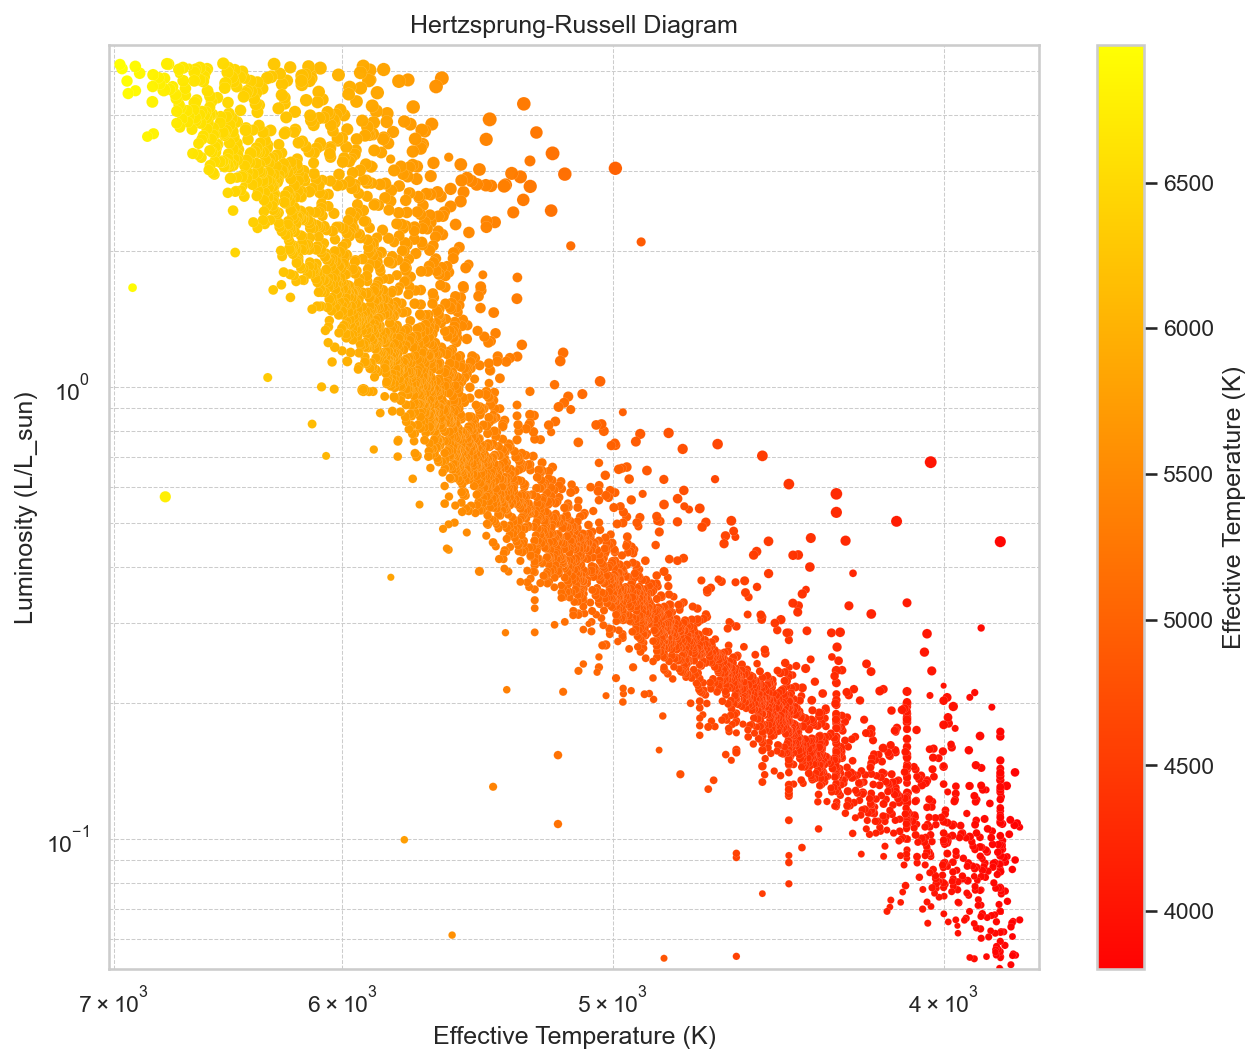

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your DataFrame

# Plotting the H-R Diagram with color transition from red to yellow
plt.figure(figsize=(10, 8), dpi=150)
plt.scatter(
    merged_df['T_eff [K]'], 
    merged_df['Luminosity [L_Sun]'], 
    c=merged_df['T_eff [K]'],  # Color by temperature
    cmap='autumn',  # Use autumn colormap for red to yellow transition
    alpha=0.99, 
    edgecolors='w',  # Use white for edges
    linewidths=0.05,  # Set edge width
    s=merged_df['Radius [R_Sun]'] * 20  # Scale the radius for visibility
)
plt.colorbar(label='Effective Temperature (K)')  # Add color bar
plt.xscale('log')
plt.yscale('log')
plt.xlim(min(merged_df['T_eff [K]'])-50, max(merged_df['T_eff [K]'])+50)  # Set the same x range
plt.ylim(min(merged_df['Luminosity [L_Sun]']), max(merged_df['Luminosity [L_Sun]'])+0.5)  # Set the same y range
plt.gca().invert_xaxis()  # Invert x-axis for temperature
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Luminosity (L/L_sun)')
plt.title('Hertzsprung-Russell Diagram')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig('../figures/HR_diagram.png')
plt.show()


In [155]:
def plot_stellar_properties_vs_temperature(merged_df, detection_limit):
    """
    Plots various stellar properties as a function of effective temperature.

    Parameters:
    merged_df (DataFrame): DataFrame containing stellar data with columns for effective temperature and other properties.
    """
    fig, axs = plt.subplots(2, 4, figsize=(12, 6), dpi=300)

    # Flatten the axs array for easier iteration
    axs = axs.flatten()

    # List of columns to plot, including the new Density column
    columns = [
        'V_mag', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 
        'Density [Solar unit]', 'HZ_limit [AU]', 'RV precision [m/s]', 'HZ Detection Limit [M_Earth]'
    ]

    # Define a color palette
    colors = plt.cm.viridis(np.linspace(0, 1, len(columns)))

    # Plot each column
    for i, col in enumerate(columns):
        axs[i].scatter(merged_df['T_eff [K]'], merged_df[col], alpha=0.2, color=colors[i], s=10)
        axs[i].set_xlabel('$T_{eff}$ (K)', fontsize=12)
        axs[i].set_ylabel(col, fontsize=12)
        axs[i].grid(True, linestyle='--', alpha=0.6)

    # Add a main title
    fig.suptitle('Stellar Properties as a Function of Temperature (' + str(len(merged_df)) + ' < ' + str(detection_limit) + ' M_Earth)', fontsize=14)

    # Adjust the layout and display the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('../figures/stellar_properties_vs_temperature.png')
    plt.show()

Number of stars with HZ Detection Limit <= 1.5: 132


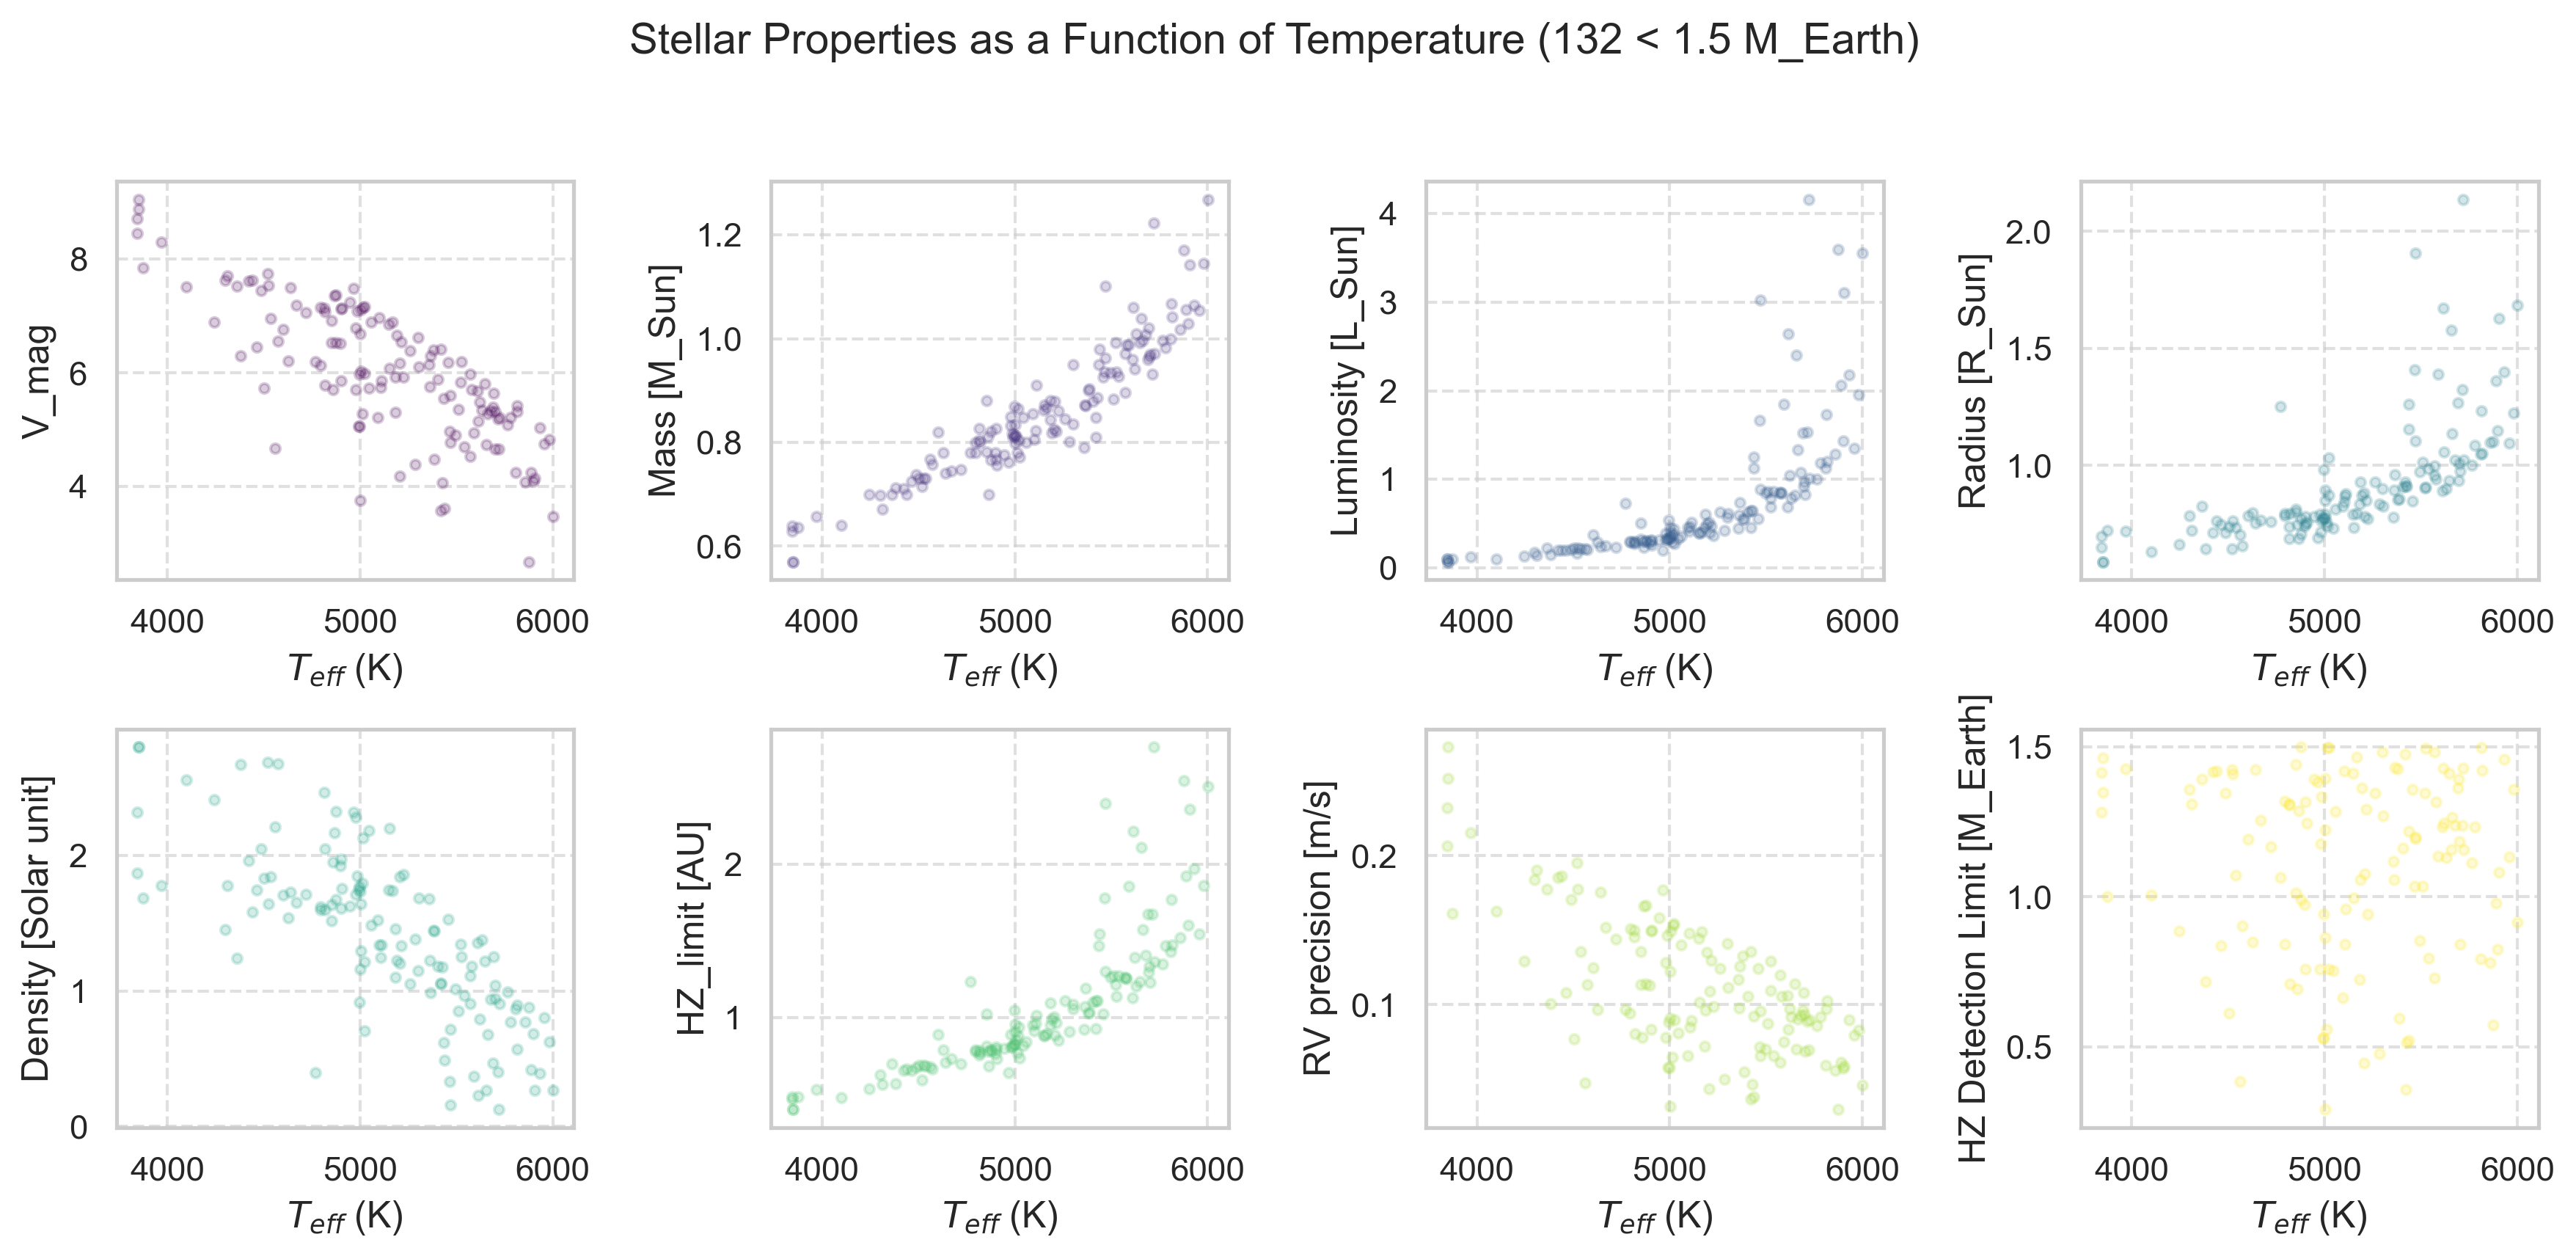

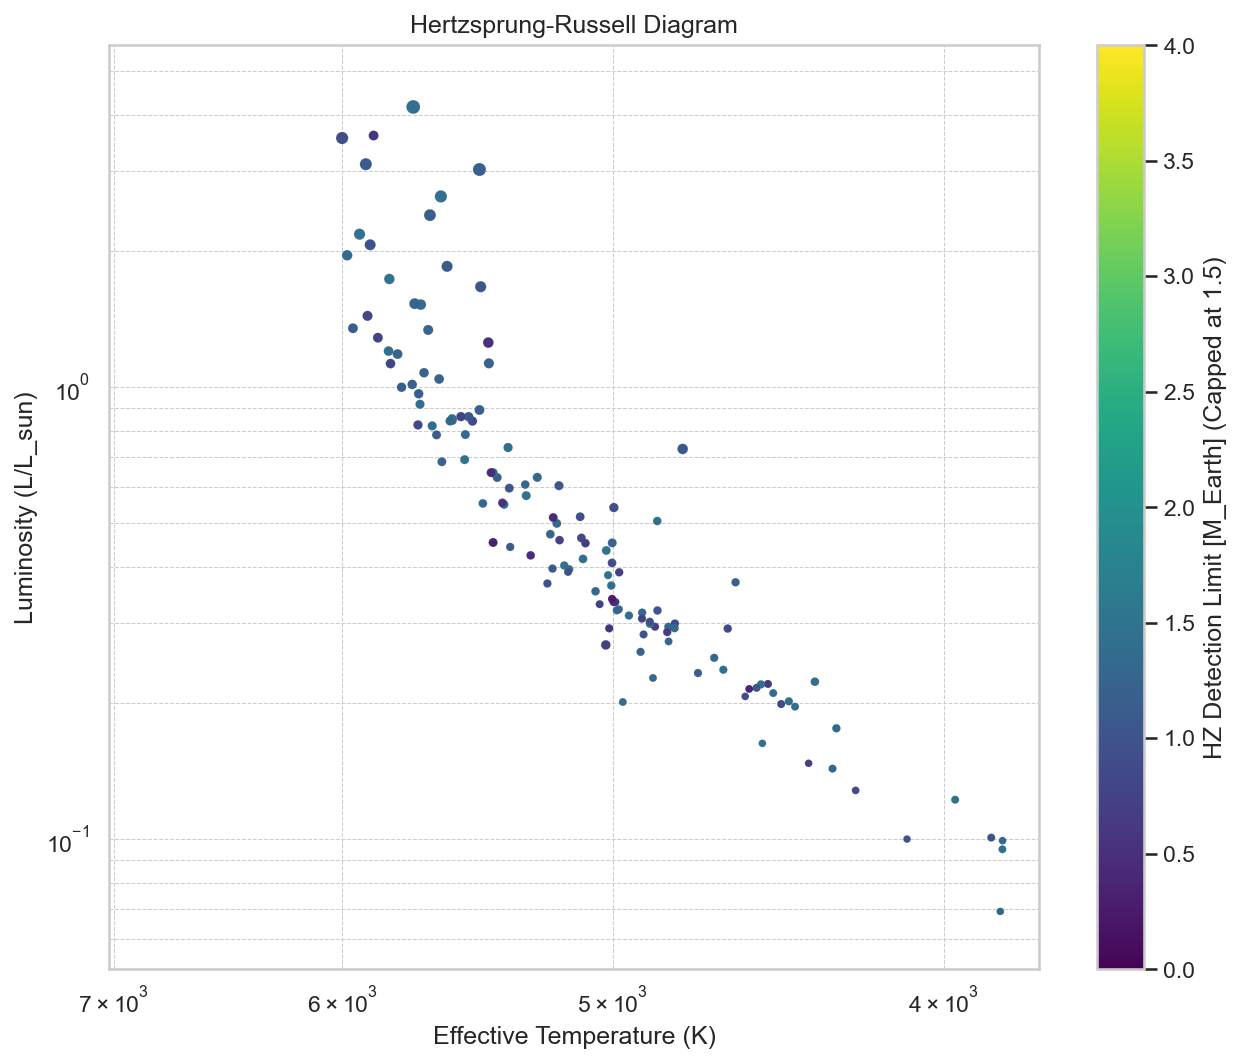

In [156]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your DataFrame

# Option to switch between original and filtered plot
use_filtered_data = True  # Set to False to use the original data

if use_filtered_data:
    # Filter the DataFrame to include only rows where 'HZ Detection Limit [M_Earth]' is less than 1.5
    Detection_Limit = 1.5
    data_to_plot = merged_df[merged_df['HZ Detection Limit [M_Earth]'] <= Detection_Limit]
    color_data = data_to_plot['HZ Detection Limit [M_Earth]']
    colorbar_label = 'HZ Detection Limit [M_Earth] (Capped at ' + str(Detection_Limit) + ')'
    filename = '../figures/HR_diagram_HZ_detection_limit_filtered.png'
    print('Number of stars with HZ Detection Limit <= ' + str(Detection_Limit) + ':', len(data_to_plot))
    plot_stellar_properties_vs_temperature(data_to_plot, Detection_Limit)
else:
    # Use the original data with capped values
    data_to_plot = merged_df
    color_data = np.minimum(merged_df['HZ Detection Limit [M_Earth]'], 4)
    colorbar_label = 'HZ Detection Limit [M_Earth] (Capped at 4)'
    filename = '../figures/HR_diagram_HZ_detection_limit.png'

# Plotting the H-R Diagram without gradient background and with color-coded circles by HZ Detection Limit
plt.figure(figsize=(10, 8), dpi=150)

# Scatter plot with circles color-coded by HZ Detection Limit
sc = plt.scatter(
    data_to_plot['T_eff [K]'], 
    data_to_plot['Luminosity [L_Sun]'], 
    c=color_data,  # Use appropriate color data
    cmap='viridis',  # Use viridis colormap for detection limit
    alpha=0.99, 
    edgecolors='grey',  # Use grey for edges
    linewidths=0.05,  # Set edge width
    s=data_to_plot['Radius [R_Sun]'] * 20  # Scale the radius for visibility
)

# Add a color bar with the same scaling
cbar = plt.colorbar(sc, label=colorbar_label)
sc.set_clim(0, 4)  # Set color bar limits to maintain the same scaling

plt.xscale('log')
plt.yscale('log')
plt.xlim(min(merged_df['T_eff [K]'])-50, max(merged_df['T_eff [K]'])+50)  # Set the same x range
plt.ylim(min(merged_df['Luminosity [L_Sun]']), max(merged_df['Luminosity [L_Sun]'])+0.5)  # Set the same y range
plt.gca().invert_xaxis()  # Invert x-axis for temperature
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Luminosity (L/L_sun)')
plt.title('Hertzsprung-Russell Diagram')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig(filename)
plt.show()



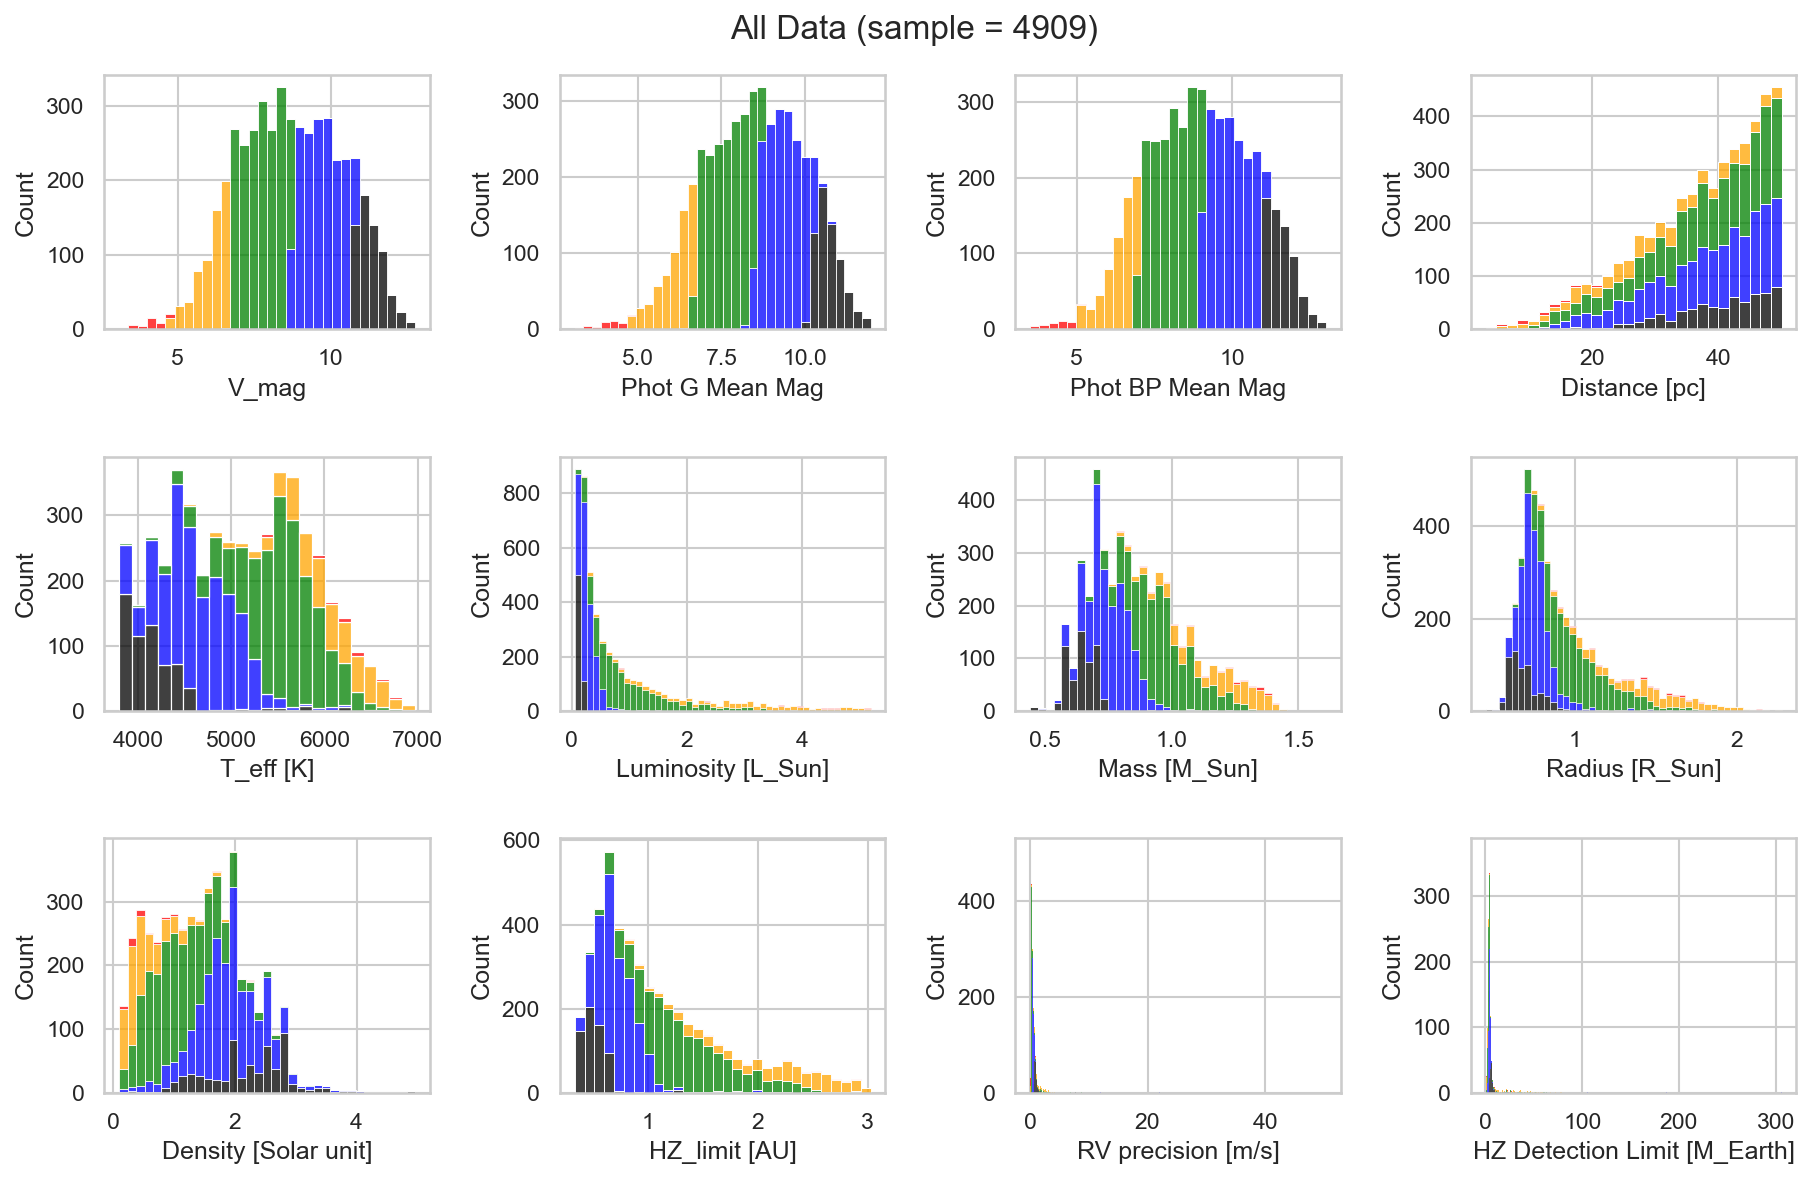

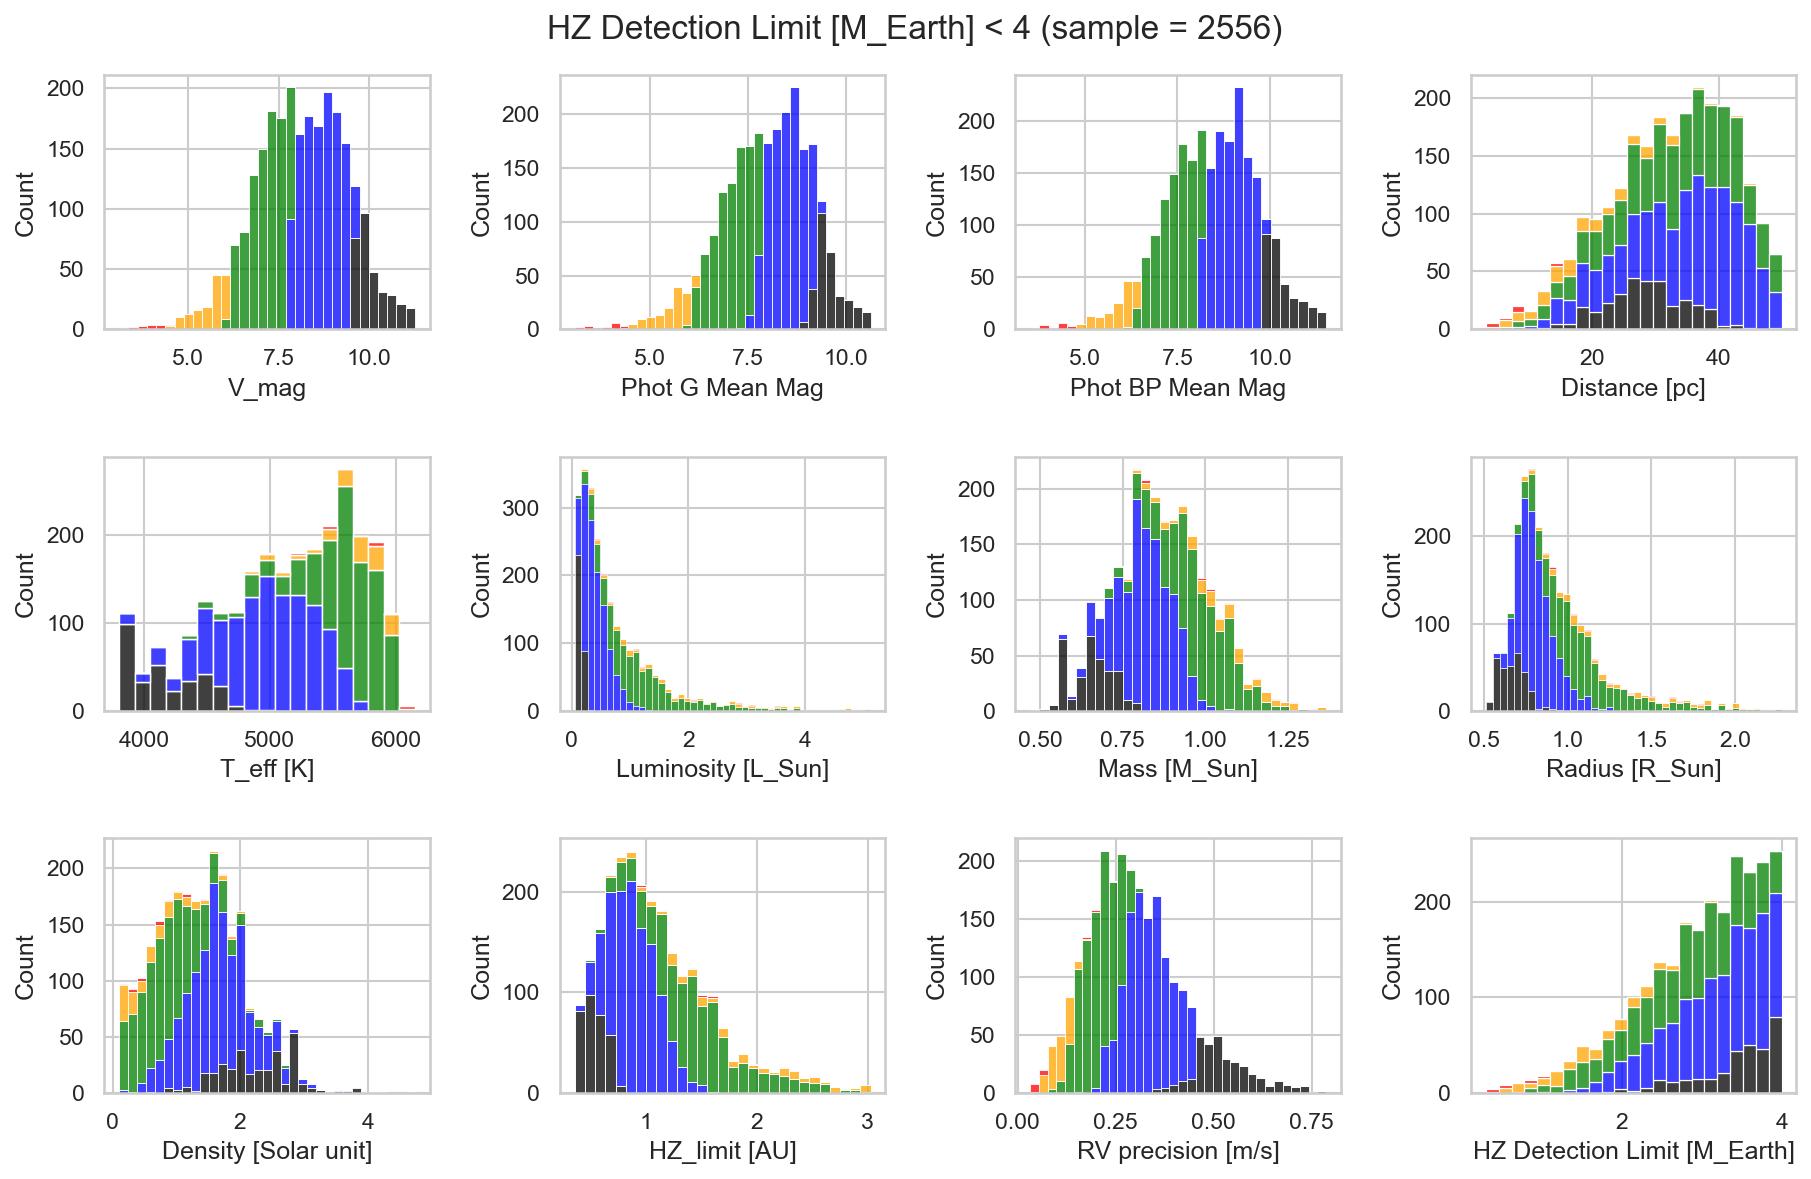

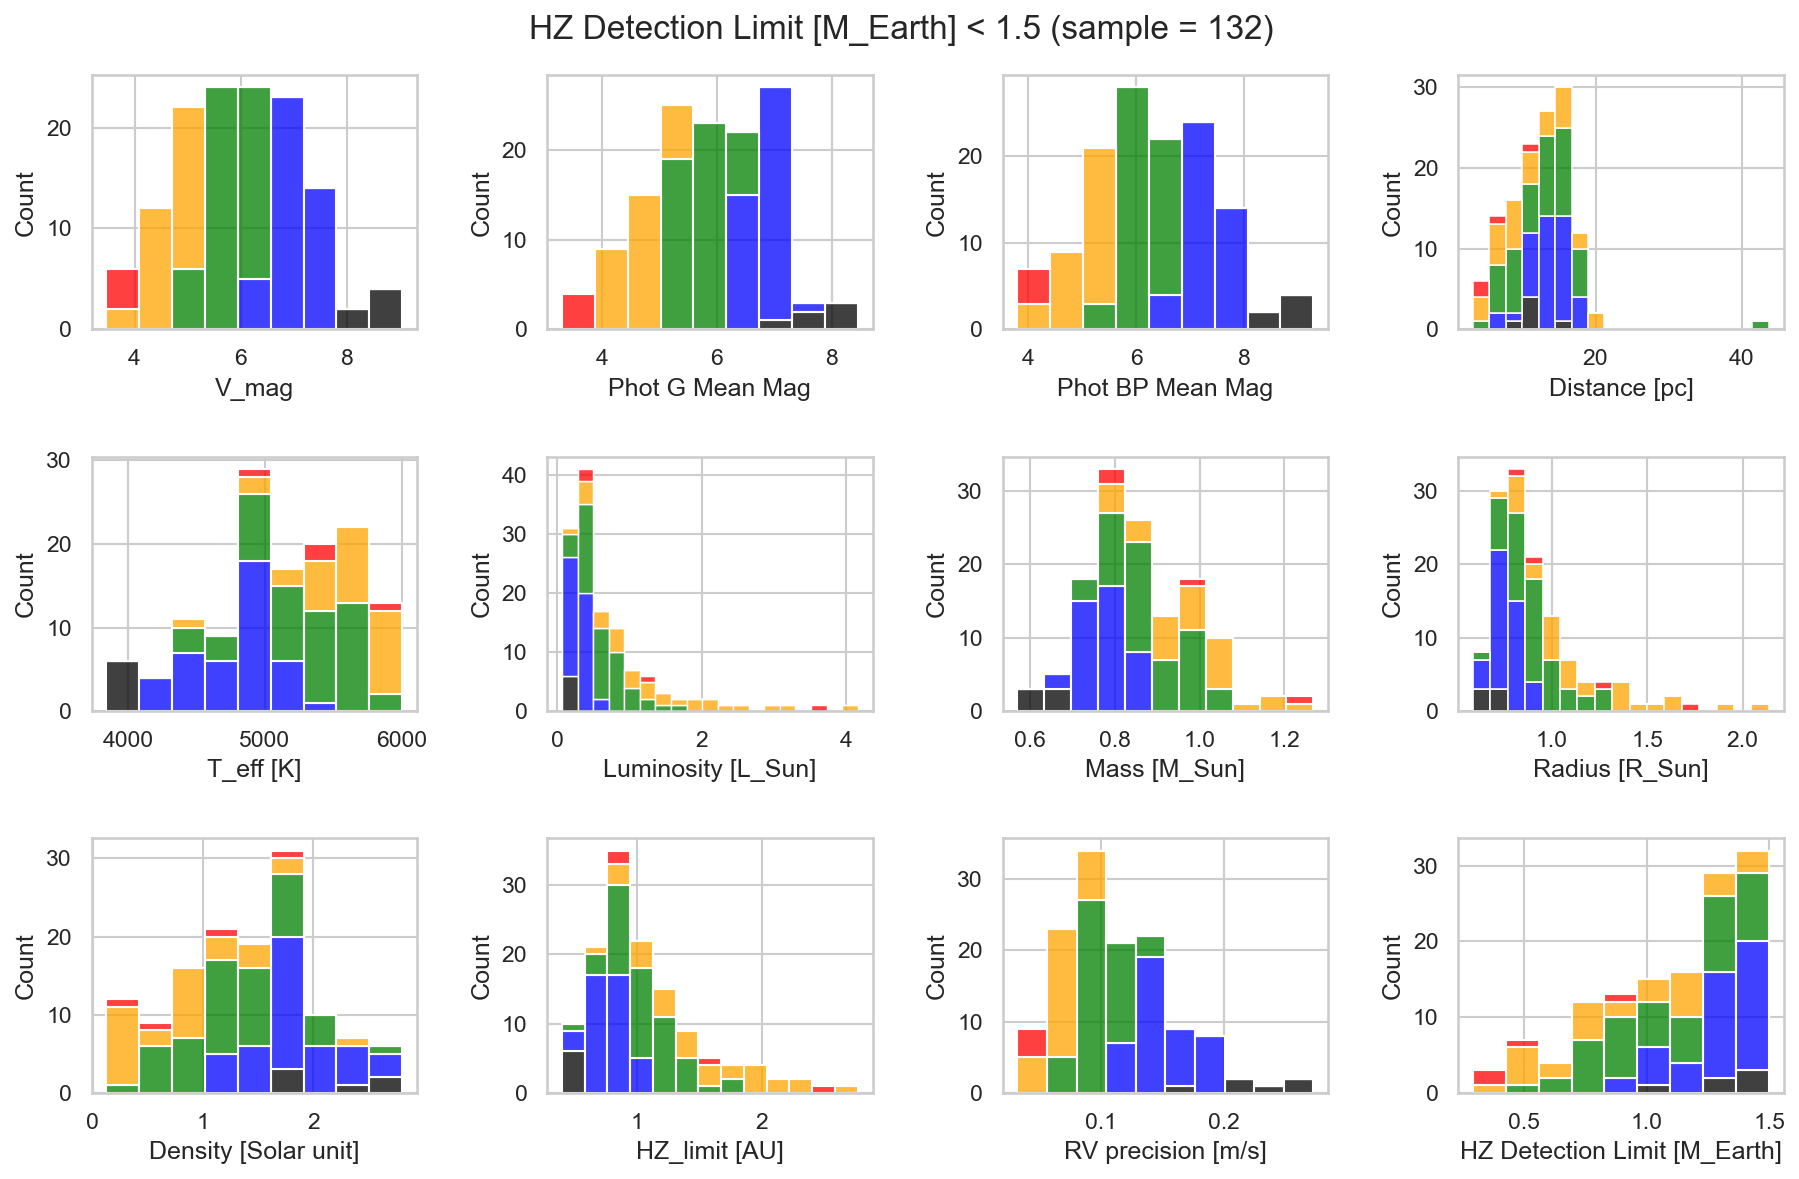

In [157]:
# Set the theme for the plot
sns.set_theme(style="whitegrid")

# Calculate distance and add it to the DataFrame
merged_df['Distance [pc]'] = 1000 / merged_df['Parallax']


columns_to_plot = [
    'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Distance [pc]',
    'T_eff [K]', 'Luminosity [L_Sun]', 'Mass [M_Sun]', 'Radius [R_Sun]', 
    'Density [Solar unit]', 'HZ_limit [AU]', 'RV precision [m/s]', 'HZ Detection Limit [M_Earth]'
]


# Define reversed grayscale colors for each group
group_colors = {
    'Brightest': 'red',
    'Bright': 'orange',
    'Dim': 'green',
    'Dimmer': 'blue',
    'Dimmest': 'black'
}

def plot_histograms(df, title, filename):
    # Divide V_mag into 5 groups and assign reversed grayscale colors
    v_mag_bins = np.linspace(df['V_mag'].min(), df['V_mag'].max(), 6)
    df['V_mag_group'] = pd.cut(df['V_mag'], bins=v_mag_bins, labels=group_colors.keys())

    # Set up the plot
    fig, axes = plt.subplots(3, 4, figsize=(12, 8), dpi=150)
    fig.suptitle(title + ' (sample = ' + str(len(df)) + ')', fontsize=16)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Create histograms with color coding
    for i, column in enumerate(columns_to_plot):
        if column in df.columns:
            sns.histplot(data=df, x=column, ax=axes[i], hue='V_mag_group', palette=group_colors, multiple='stack', legend=False)
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Count')
        else:
            axes[i].set_visible(False)  # Hide axes if column is not available

    # Adjust layout and display
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.5, wspace=0.4, left=0.05, right=0.99)
    plt.savefig(filename)
    plt.show()

# Plot for the entire DataFrame
plot_histograms(merged_df, 'All Data', '../figures/star_properties_histograms.png')

# save the merged_df to an excel file
output_path = directory + 'Gaia_homogeneous_target_selection_Jinglin_2025.01.09.xlsx'
merged_df.sort_values(by='HZ Detection Limit Simplified [M_Earth]').to_excel(output_path, index=False)
adjust_column_widths(output_path)

# Plot for HZ Detection Limit < 4
filtered_df_4 = merged_df[merged_df['HZ Detection Limit [M_Earth]'] < 4].copy()
plot_histograms(filtered_df_4, 'HZ Detection Limit [M_Earth] < 4', '../figures/star_properties_histograms_filtered_4.png')

# save the filtered_df_4 to an excel file
output_path = directory + 'Gaia_homogeneous_target_selection_M_earth_4_Jinglin_2025.01.09.xlsx'
filtered_df_4.sort_values(by='HZ Detection Limit Simplified [M_Earth]').to_excel(output_path, index=False)
adjust_column_widths(output_path)

# Plot for HZ Detection Limit < 1.5
filtered_df_1_5 = merged_df[merged_df['HZ Detection Limit [M_Earth]'] < 1.5].copy()
plot_histograms(filtered_df_1_5, 'HZ Detection Limit [M_Earth] < 1.5', '../figures/star_properties_histograms_filtered_1_5.png')

# save the filtered_df_1_5 to an excel file
output_path = directory + 'Gaia_homogeneous_target_selection_M_earth_1.5_Jinglin_2025.01.09.xlsx'
filtered_df_1_5.sort_values(by='HZ Detection Limit Simplified [M_Earth]').to_excel(output_path, index=False)
adjust_column_widths(output_path)



### Comparison with Ralf's results

In [158]:
# df_Ralf = pd.read_excel('../data/Ralf/2ES_targetlist_astrid_export_2024Nov_comments.xlsx', engine='openpyxl', header=1)
df_Ralf = pd.read_excel('../data/Ralf/2ES_targetlist_astrid_export_2024Dec_comments.xlsx', engine='openpyxl', header=1)
df_Ralf = df_Ralf[df_Ralf['prio'] != 3]

print(len(df_Ralf))
print(df_Ralf.columns)

187
Index(['star_ID  ', 'prio', 'sys            ', 'R.A.[deg]', 'R.A.[min] ',
       'R.A.[sec]  ', 'DEC [deg]', 'DEC [amin]', 'DEC [arcs]  ',
       'dist [pc]         ', 'magV     ', 'magJ ', 'magH ', 'magK ', 'spT   ',
       'Teff ', 'Teff_e', 'met  ', 'mass ', 'mass_e', 'lum    ', 'lum_e',
       'R*   ', 'R*_e', 'vsini ', 'vsini_e', 'logg', 'logg_e', 'age  ',
       'age_e', 'Protmax', 'Protmax_e', 'Prot', 'Prot_e', 'i*', 'i*_e',
       'i_dd  ', 'i_dd_e', 'Prot_d', 'Prot_d_e', 'dd_t1', 'dd_l1', 'dd_r1',
       'dd_l2', 'RV_Prec(390-870) 10m', 'RV_Prec(390-870) 30m', 'HZ Rin',
       'HZ Rout', 'P(HZ)', 'mdl(hz) 30min', 'Notes RL', 'Notes MH'],
      dtype='object')


Merge df_Ralf and merged_df for the same stars. 

In [159]:
# ---------------------------------------------------------------- #
#  HD
# ---------------------------------------------------------------- #
# Split 'HD Number' into two separate columns 'HD Number 1' and 'HD Number 2'
merged_df[['HD Number 1', 'HD Number 2']] = merged_df['HD Number'].str.split(', ', expand=True, n=1)
# Clean up 'HD Number 1' and 'HD Number 2' by removing extra spaces after 'HD'
merged_df['HD Number 1'] = merged_df['HD Number 1'].str.replace(r'HD\s+', 'HD', regex=True)
merged_df['HD Number 2'] = merged_df['HD Number 2'].fillna('').str.replace(r'HD\s+', 'HD', regex=True)

# ---------------------------------------------------------------- #
#  HIP
# ---------------------------------------------------------------- #
merged_df['HIP Number'] = merged_df['HIP Number'].apply(lambda x: f'HIP{x}' if pd.notna(x) and x != '' and not str(x).startswith('HIP') else x)

# ---------------------------------------------------------------- #
#  GJ
# ---------------------------------------------------------------- #    
# Split 'GJ Number' into two separate columns 'GJ Number 1' and 'GJ Number 2'
merged_df[['GJ Number 1', 'GJ Number 2']] = merged_df['GJ Number'].str.split(', ', expand=True, n=1)
# Clean up 'GJ Number 1' and 'GJ Number 2' by removing extra spaces after 'GJ'
merged_df['GJ Number 1'] = merged_df['GJ Number 1'].str.replace(r'\s+', '', regex=True)
merged_df['GJ Number 2'] = merged_df['GJ Number 2'].fillna('').str.replace(r'\s+', '', regex=True)


# ---------------------------------------------------------------- #
#  Merge
# ---------------------------------------------------------------- #
# Perform left merges on various columns and combine results
merge_keys = ['HD Number 1', 'HD Number 2', 'HIP Number', 'GJ Number 1', 'GJ Number 2']
merged_RJ = pd.concat([df_Ralf.merge(merged_df, left_on='star_ID  ', right_on=key, how='left') for key in merge_keys])

# Sort the combined DataFrame by 'source_id' to prioritize non-null values
merged_RJ.sort_values(by='source_id', ascending=False, inplace=True)

# Remove duplicate entries based on 'star_ID  ', keeping the first occurrence
merged_RJ.drop_duplicates(subset='star_ID  ', keep='first', inplace=True)

# Reset the index of the final DataFrame
merged_RJ.reset_index(drop=True, inplace=True)

# Save the final DataFrame to an Excel file
filename = '../results/merged_RJ_2025.01.09.xlsx'
merged_RJ.sort_values(by=['prio', 'HD Number'], ascending=[True, True], inplace=True)

# Apply color formatting to fonts of the whole row based on 'prio' values
# and highlight rows where 'source_id' is missing in yellow
def apply_color_formatting(workbook, worksheet):
    dark_green_format = workbook.add_format({'font_color': '#006400'})
    orange_format = workbook.add_format({'font_color': '#FFA500'})
    yellow_format = workbook.add_format({'bg_color': '#FFFF00'})  # Yellow background for missing 'source_id'
    
    for row_num, (prio_value, source_id) in enumerate(zip(merged_RJ['prio'], merged_RJ['source_id']), start=1):
        if pd.isna(source_id):
            worksheet.set_row(row_num, None, yellow_format)
        elif prio_value == 0:
            worksheet.set_row(row_num, None, dark_green_format)
        elif prio_value == 1:
            worksheet.set_row(row_num, None, orange_format)

# Save the DataFrame to an Excel file with formatting
try:
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        merged_RJ.to_excel(writer, index=False)
        workbook = writer.book
        worksheet = writer.sheets['Sheet1']
        apply_color_formatting(workbook, worksheet)
except ModuleNotFoundError:
    print("xlsxwriter module not found. Please install it using 'pip install xlsxwriter'.")

adjust_column_widths(filename)

In [160]:
def plot_scatter_with_options(df, col_x, col_y, min_value=None, max_value=None, label=False):
    # Create a scatter plot with color mapping
    plt.figure(figsize=(8, 6), dpi=150)
    scatter = plt.scatter(
        df[col_x], 
        df[col_y], 
        c=df['T_eff [K]'], 
        cmap='autumn', 
        edgecolor='k', 
        alpha=0.7
    )

    # Add titles and labels
    # plt.title('Selection Crossmatch', fontsize=14)
    plt.xlabel(f'{col_x} (Ralf)', fontsize=12)
    plt.ylabel(f'{col_y} (Jinglin)', fontsize=12)

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('T_eff [K]', fontsize=12)

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot the x = y line
    if min_value is None:
        min_value = min(min(df[col_x]), min(df[col_y]))
    if max_value is None:
        max_value = max(max(df[col_x]), max(df[col_y]))
    plt.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--')
    plt.xlim(min_value, max_value)
    plt.ylim(min_value, max_value)

    if label:
        # Add labels to each point
        x_range = max_value - min_value
        x_offset = x_range * 0.01
        for i, name in enumerate(df['star_ID  ']):
            if (df[col_x][i] > min_value) and (df[col_x][i] < max_value) and (df[col_y][i] > min_value) and (df[col_y][i] < max_value):
                plt.text(df[col_x][i] - x_offset, df[col_y][i], name, fontsize=5, ha='right')    

    plt.tight_layout()
    plt.savefig('../figures/crossmatch_' + col_y.strip().replace(" ", "_").replace("[", "").replace("]", "").replace("/", "") + '.png')
    # Show the plot
    plt.show()


In [161]:
merged_RJ

star_ID    prio  sys              R.A.[deg]  R.A.[min]   R.A.[sec]    \
102      HD55     0  Unknown system           0           5       17.689   
171    HD2025     0  Unknown system           0          24       25.933   
104    HD2151     0  Unknown system           0          25       45.070   
85    HD4378A     0  Multiple system          0          45       48.287   
163    HD4628     0  Multiple system          0          48       22.976   
..        ...   ...              ...        ...         ...          ...   
181  HD125072     2  Unknown system          14          19        4.834   
182   HD99492     2  Multiple system         11          26       46.278   
184  HD128621     2  Multiple system         14          39       35.063   
185  HD128620     2  Multiple system         14          39       36.494   
186  HD173667     2  Multiple system         18          45       39.726   

     DEC [deg]  DEC [amin]  DEC [arcs]    dist [pc]           ...  \
102        -67          49        57.323             16.3920  ...   
171        -27           1        36.381             17.9130  ...   
104        -77          15        15.286              7.4590  ...   
85         -41          54        33.080             15.7250  ...   
163          5          16        50.209              7.4350  ...   
..         ...         ...           ...                 ...  ...   
181        -59          22        44.537             11.8200  ...   
182          3           0        22.757             18.1610  ...   
184        -60          50        15.099              1.3470  ...   
185        -60          50         2.373              1.3475  ...   
186         20          32        46.713             19.3520  ...   

     Stellar Parameter Source  SIMBAD Spectral Type  Readable Spectral Type  \
102                      GAIA                  None                    None   
171                      GAIA                  None                    None   
104        SIMBAD + empirical                   G0V                     G0V   
85         SIMBAD + empirical                  K5Ve                     K5V   
163                      GAIA                  None                    None   
..                        ...                   ...                     ...   
181                       NaN                   NaN                     NaN   
182                       NaN                   NaN                     NaN   
184                       NaN                   NaN                     NaN   
185                       NaN                   NaN                     NaN   
186                       NaN                   NaN                     NaN   

     HZ Detection Limit Simplified [M_Earth] Distance [pc]  V_mag_group  \
102                                 1.929490     16.391723          Dim   
171                                 1.759051     17.913354          Dim   
104                                 0.573097      7.478346          NaN   
85                                  1.948665     15.724803          Dim   
163                                 0.693237      7.435229       Bright   
..                                       ...           ...          ...   
181                                      NaN           NaN          NaN   
182                                      NaN           NaN          NaN   
184                                      NaN           NaN          NaN   
185                                      NaN           NaN          NaN   
186                                      NaN           NaN          NaN   

     HD Number 1  HD Number 2  GJ Number 1  GJ Number 2  
102         HD55                       GJ3               
171       HD2025                    GJ18.0         GJ18  
104       HD2151                      GJ19               
85       HD4378A                     GJ32A               
163       HD4628                      GJ33               
..           ...          ...          ...          ...  
181   

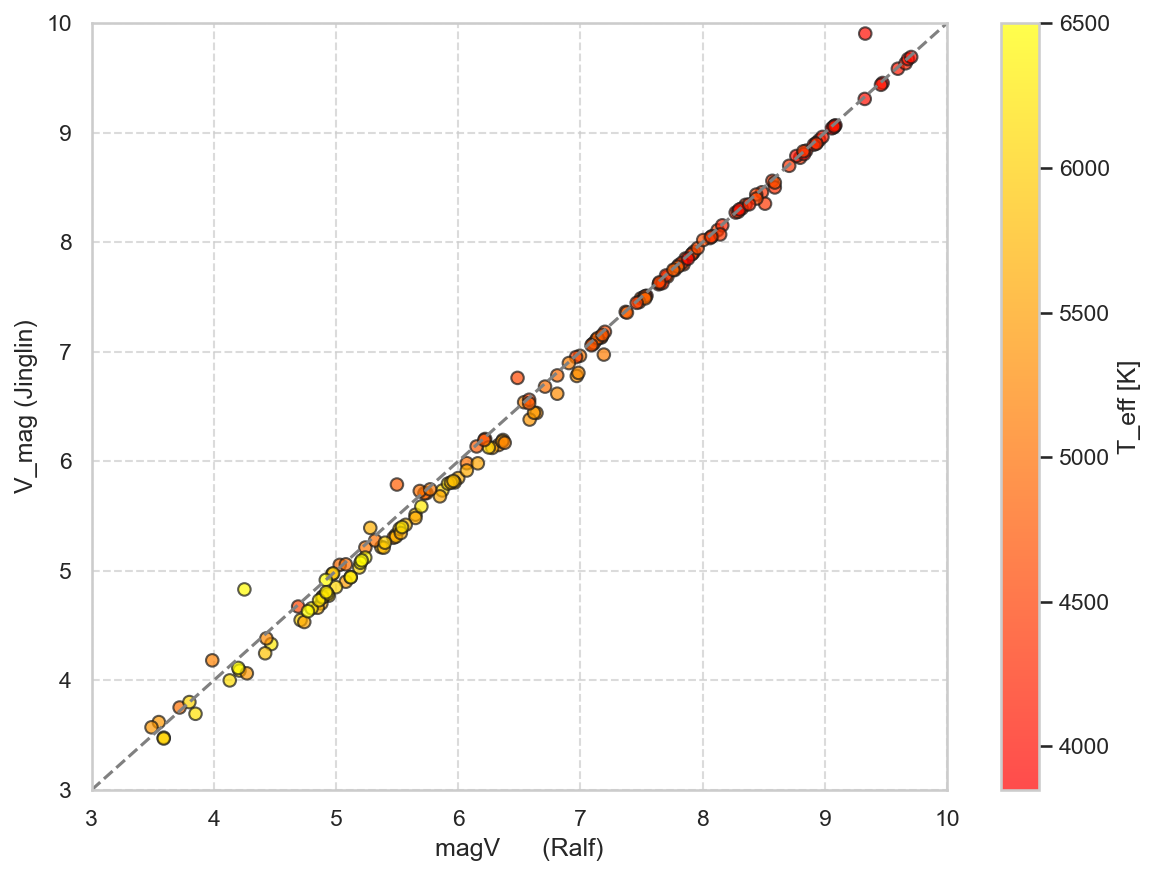

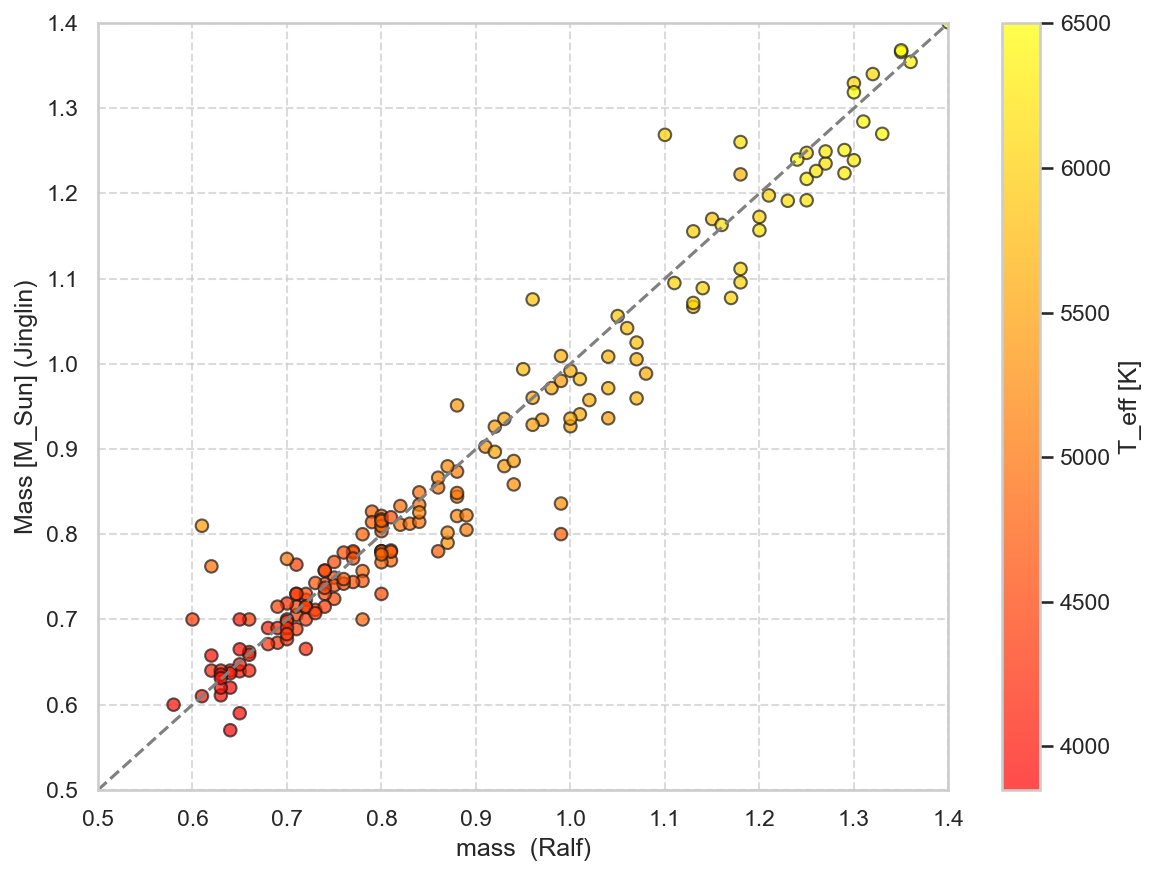

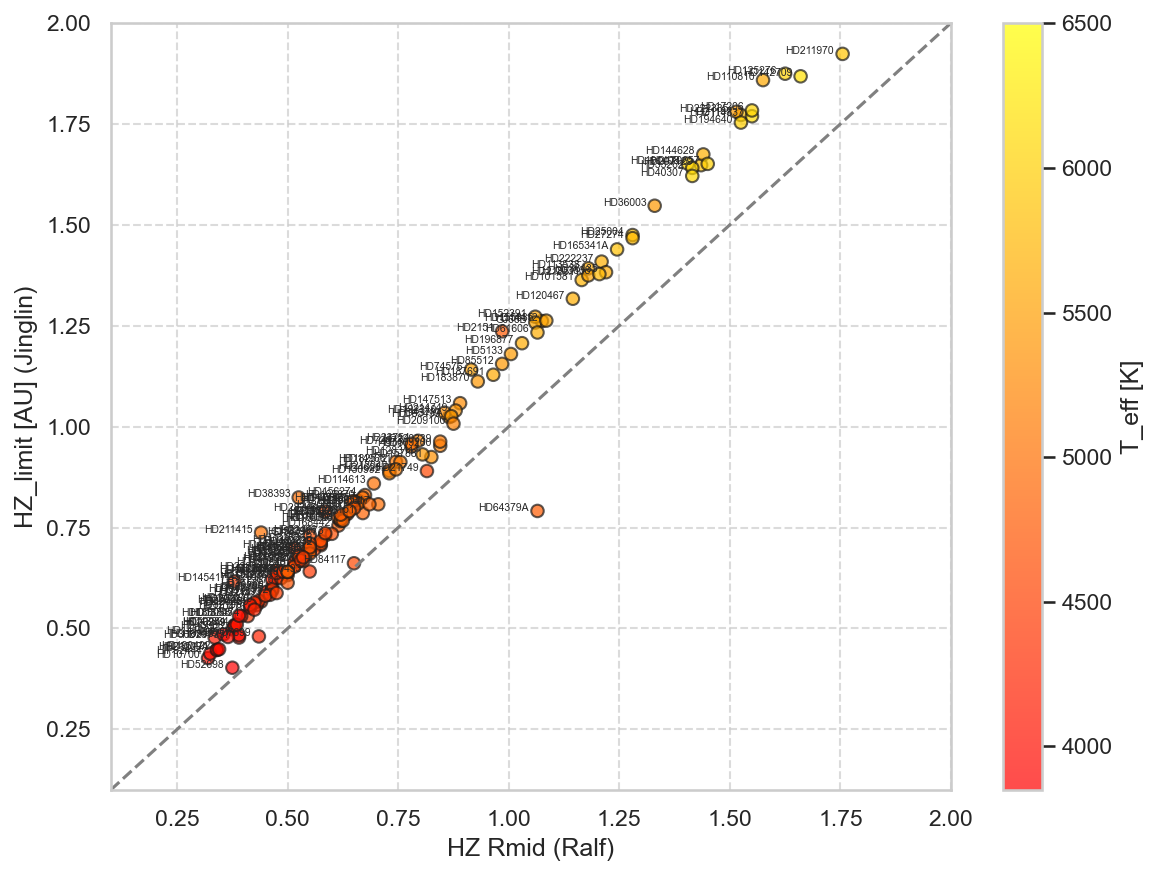

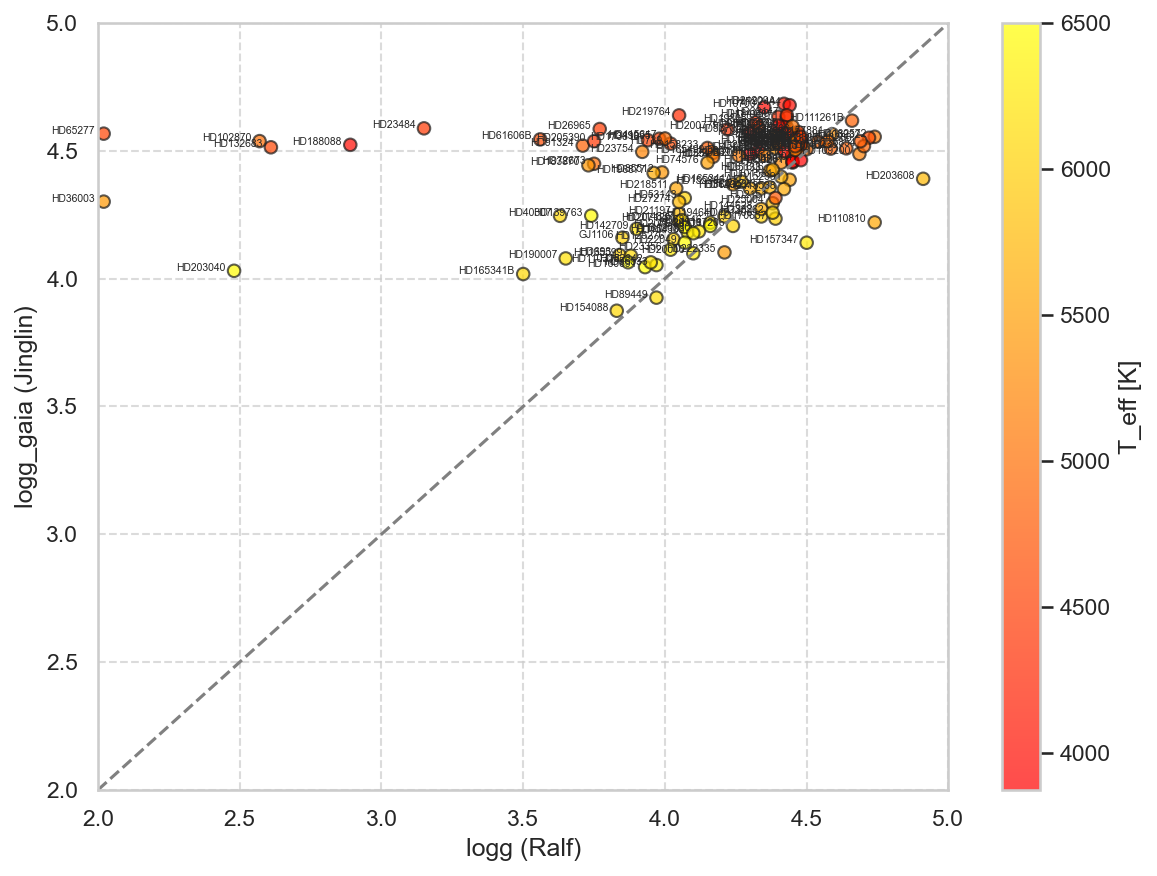

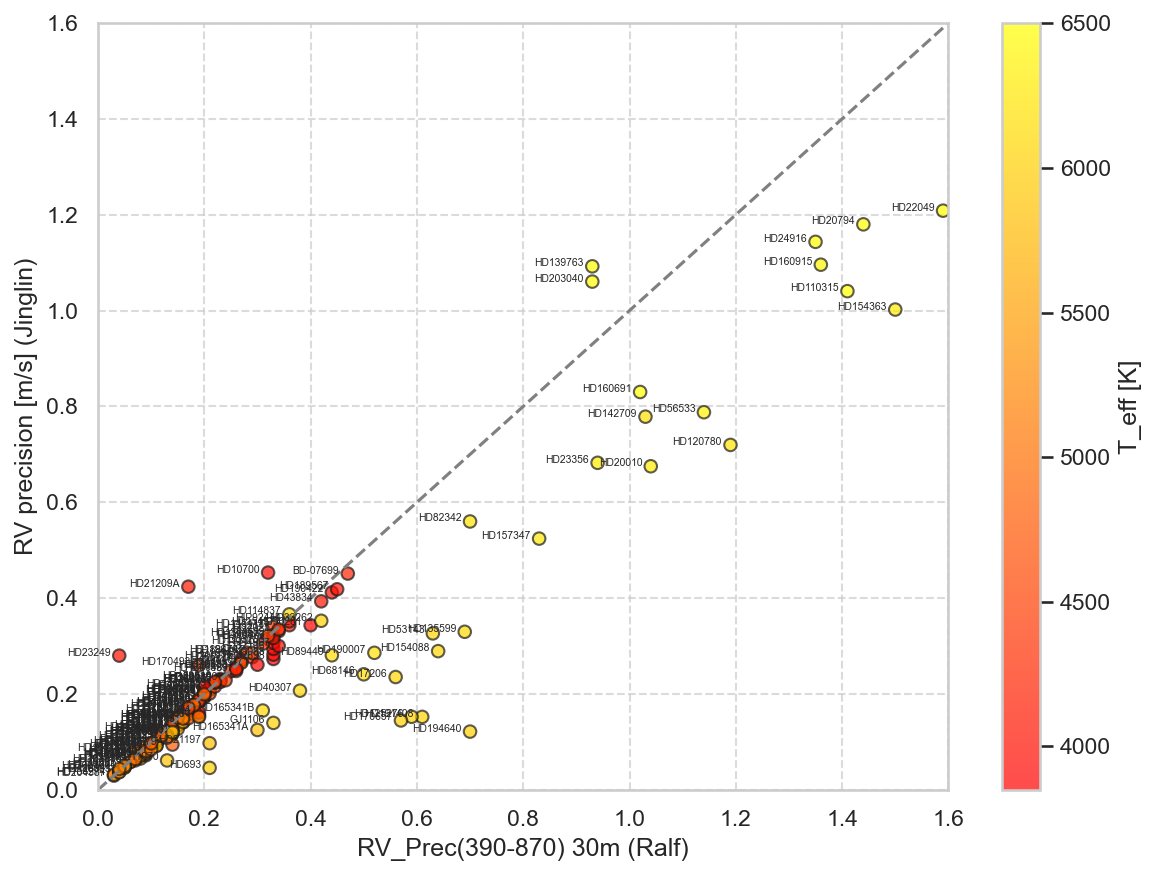

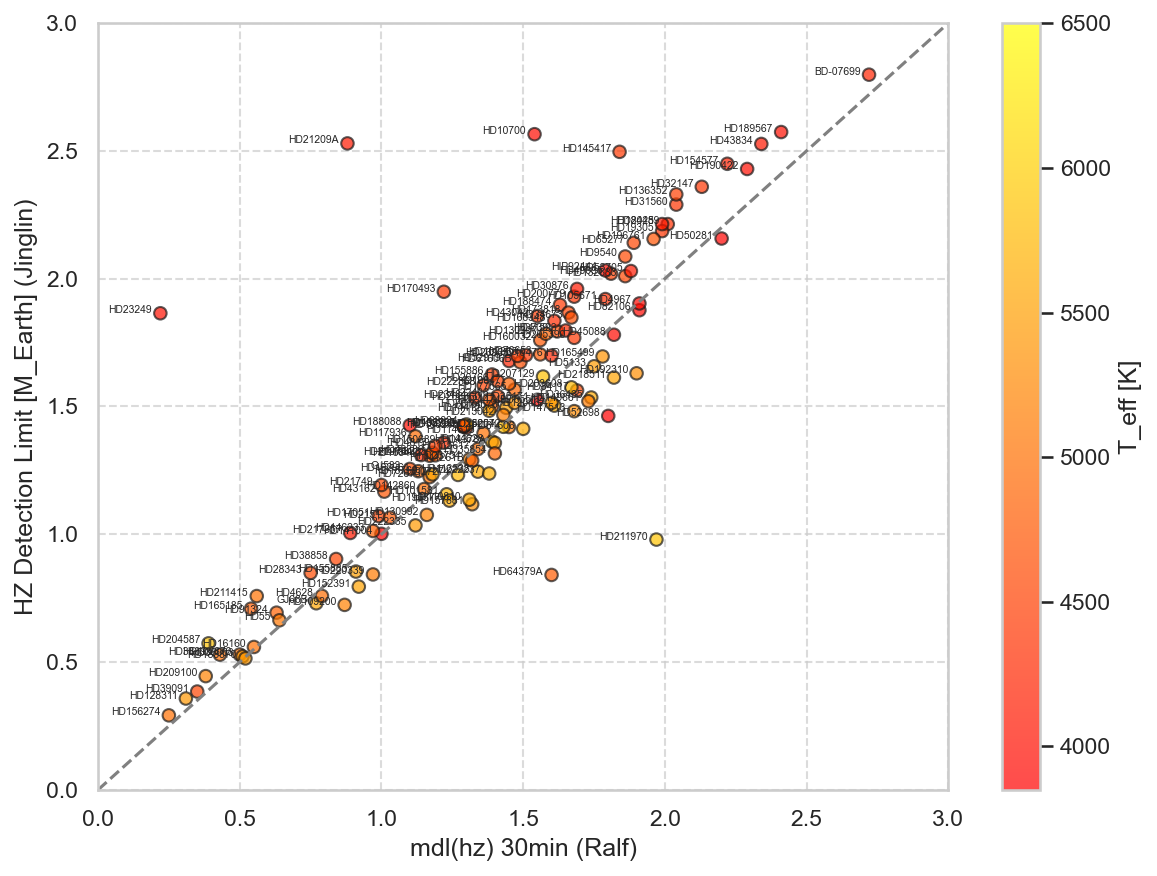

In [162]:
merged_RJ['HZ Rmid'] = (merged_RJ['HZ Rin'] + merged_RJ['HZ Rout']) / 2
plot_scatter_with_options(merged_RJ, 'magV     ', 'V_mag', min_value = 3, max_value = 10)
plot_scatter_with_options(merged_RJ, 'mass ', 'Mass [M_Sun]', min_value = 0.5, max_value = 1.4)
plot_scatter_with_options(merged_RJ, 'HZ Rmid', 'HZ_limit [AU]', min_value = 0.1, max_value = 2, label=True)
plot_scatter_with_options(merged_RJ, 'logg', 'logg_gaia', min_value = 2, max_value = 5, label=True)
plot_scatter_with_options(merged_RJ, 'RV_Prec(390-870) 30m', 'RV precision [m/s]', min_value = 0, max_value = 1.6, label=True)

plot_scatter_with_options(merged_RJ, 'mdl(hz) 30min', 'HZ Detection Limit [M_Earth]', min_value = 0, max_value = 3, label=True)



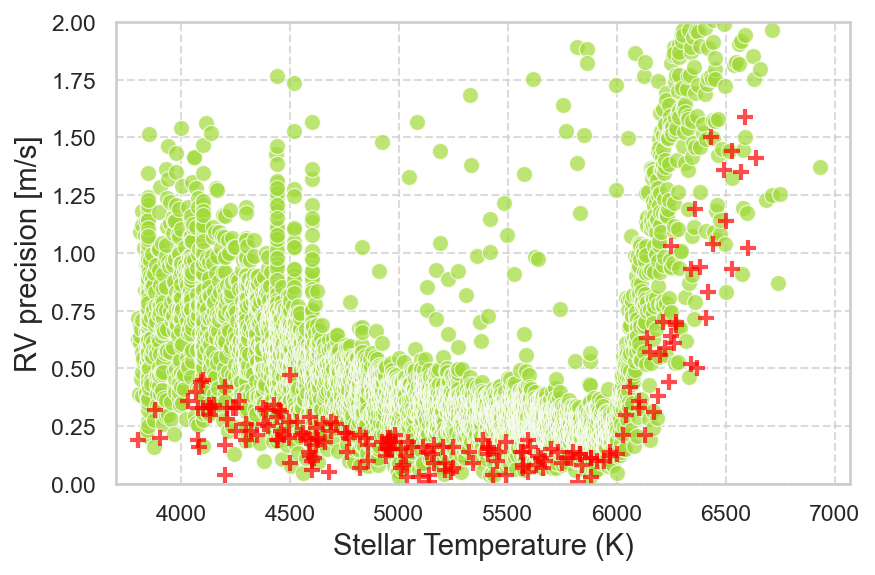

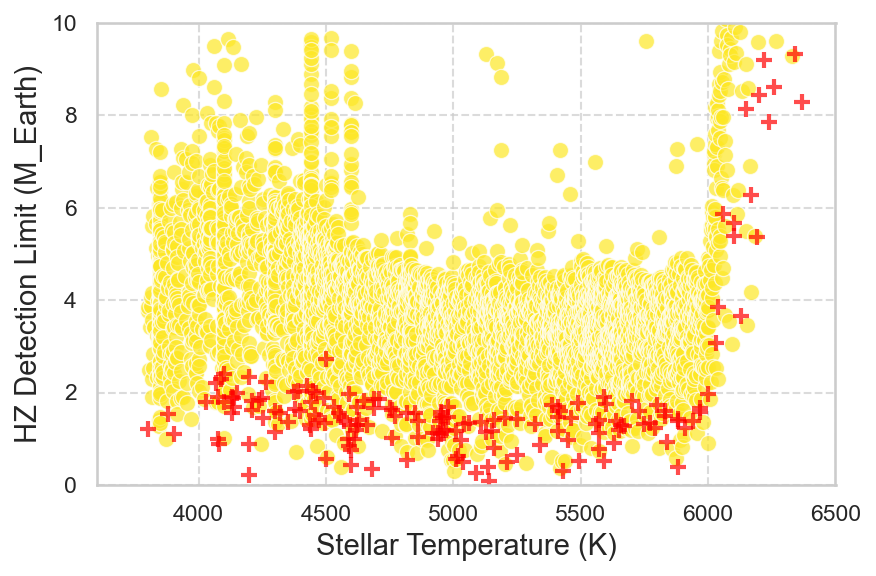

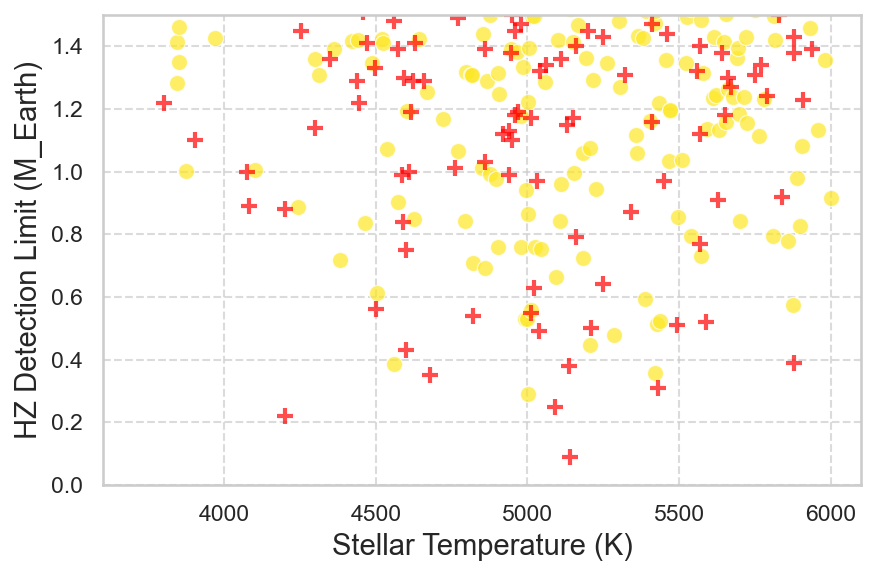

In [163]:
i = 7
colors = plt.cm.viridis(np.linspace(0, 1, 8))

# Use the function to create the plot
plot_scatter(
    x='T_eff [K]',
    y='RV precision [m/s]',
    data=merged_df,
    xlabel='Stellar Temperature (K)',
    ylabel='RV precision [m/s]',
    xlim=(min(min(merged_df['T_eff [K]']), min(df_Ralf['Teff '])) - 100, max(max(merged_df['T_eff [K]']), max(df_Ralf['Teff '])) + 100),
    ylim=(0, 2),
    filename='../figures/RV_precision_vs_temperature.png',
    color=colors[i-1],  # Assuming 'colors' is defined and 'i' is an integer index
    x2 = 'Teff ', 
    y2 = 'RV_Prec(390-870) 30m',
    data2 = df_Ralf,
    color2 = 'red'
)

plot_scatter(
    x='T_eff [K]',
    y='HZ Detection Limit [M_Earth]',
    data=merged_df,
    xlabel='Stellar Temperature (K)',
    ylabel='HZ Detection Limit (M_Earth)',
    xlim=(min(merged_df['T_eff [K]']) - 200, 6000 + 500),
    ylim=(0, 10),
    filename='../figures/HZ_detection_limit_vs_temperature_full.png',
    color=colors[i],  # Replace with actual color if using a list
    x2 = 'Teff ', 
    y2 = 'mdl(hz) 30min',
    data2 = df_Ralf,
    color2 = 'red'
)

plot_scatter(
    x='T_eff [K]',
    y='HZ Detection Limit [M_Earth]',
    data=merged_df,
    xlabel='Stellar Temperature (K)',
    ylabel='HZ Detection Limit (M_Earth)',
    xlim=(min(merged_df['T_eff [K]']) - 200, 6000 + 100),
    ylim=(0, 1.5),
    filename='../figures/HZ_detection_limit_vs_temperature_zoomed.png',
    color=colors[i],  # Replace with actual color if using a list
    x2 = 'Teff ', 
    y2 = 'mdl(hz) 30min',
    data2 = df_Ralf,
    color2 = 'red'
)

In [164]:
print("my results:")
print("Number of stars:", len(merged_df))
print("Number of stars with HZ Detection Limit [M_Earth] < 4:", len(merged_df[merged_df['HZ Detection Limit [M_Earth]'] < 4]))
print("Number of stars with HZ Detection Limit [M_Earth] < 1.5:", len(merged_df[merged_df['HZ Detection Limit [M_Earth]'] < 1.5]))

print("\nRalf's results:")
print("Number of stars:", len(merged_RJ))
print("Number of stars with HZ Detection Limit [M_Earth] < 4:", len(merged_RJ[merged_RJ['mdl(hz) 30min'] < 4]))
print("Number of stars with HZ Detection Limit [M_Earth] < 1.5:", len(merged_RJ[merged_RJ['mdl(hz) 30min'] < 1.5]))

my results:
Number of stars: 4909
Number of stars with HZ Detection Limit [M_Earth] < 4: 2556
Number of stars with HZ Detection Limit [M_Earth] < 1.5: 132

Ralf's results:
Number of stars: 187
Number of stars with HZ Detection Limit [M_Earth] < 4: 154
Number of stars with HZ Detection Limit [M_Earth] < 1.5: 91


In [165]:
pwd

'/Users/jinzhao/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/GitHub/2ES_target_selection/scripts'

### Comparison with Melissa's results

In [ ]:
# read SEI_target_selection.xlsx file into a pandas DataFrame
import pandas as pd
df_Melissa = pd.read_excel('../data/SEI_target_selection.xlsx')
df_Melissa['Gaia name'] = df_Melissa['Gaia name'].astype(str)

In [40]:
if 0:
    merge_on_dr2 = pd.merge(df_Melissa, merged_df, left_on='Gaia name', right_on='source_id_dr2', how='left')

    # Then, perform the merge on 'source_id_dr3'
    merge_on_dr3 = pd.merge(df_Melissa, merged_df, left_on='Gaia name', right_on='source_id_dr3', how='left')

    # Concatenate the two results and drop duplicates if necessary
    merged_result = pd.concat([merge_on_dr2, merge_on_dr3]).drop_duplicates()

    # Optionally, you can reset the index if needed
    merged_result.reset_index(drop=True, inplace=True)

    filename = directory + 'test_merged_result_MJ.xlsx'
    merged_result.to_excel(filename, index=False)
    adjust_column_widths(filename)

    len(merged_result)

In [58]:
# Merge on 'source_id_dr2' and 'source_id_dr3'
merge_on_dr2 = pd.merge(df_Melissa, merged_df, left_on='Gaia name', right_on='source_id_dr2', how='left')
merge_on_dr3 = pd.merge(df_Melissa, merged_df, left_on='Gaia name', right_on='source_id_dr3', how='left')

# Concatenate the two results
merged_result = pd.concat([merge_on_dr2, merge_on_dr3])

# Add a column to count non-missing values in each row
merged_result['non_missing_count'] = merged_result.notna().sum(axis=1)

# Sort by 'Gaia name' and 'non_missing_count' in descending order
merged_result_sorted = merged_result.sort_values(by=['Gaia name', 'non_missing_count'], ascending=[True, False])

# Drop duplicates, keeping the first occurrence (most complete row)
merged_result_unique = merged_result_sorted.drop_duplicates(subset='Gaia name', keep='first')

# Drop the auxiliary column used for sorting
merged_result_unique = merged_result_unique.drop(columns=['non_missing_count'])

# Sort the final results by the column "suitable"
merged_result_final = merged_result_unique.sort_values(by='suitable')

# Convert the values in column "Gaia name.1" to strings
merged_result_final['Gaia name.1'] = merged_result_final['Gaia name.1'].astype(str)

# Display the number of unique rows and the result
num_unique_rows = len(merged_result_final)

num_unique_rows

merged_result = merged_result_final.copy()

filename = directory + 'test_merged_result_MJ.xlsx'
merged_result.to_excel(filename, index=False)
adjust_column_widths(filename)

In [59]:
if 0: # df_consolidated_HD

    # Merge on 'source_id_dr2' and 'source_id_dr3'
    merge_on_dr2 = pd.merge(df_Melissa, df_consolidated_HD, left_on='Gaia name', right_on='source_id_dr2', how='left')
    merge_on_dr3 = pd.merge(df_Melissa, df_consolidated_HD, left_on='Gaia name', right_on='source_id_dr3', how='left')

    # Concatenate the two results
    merged_result = pd.concat([merge_on_dr2, merge_on_dr3])

    # Add a column to count non-missing values in each row
    merged_result['non_missing_count'] = merged_result.notna().sum(axis=1)

    # Sort by 'Gaia name' and 'non_missing_count' in descending order
    merged_result_sorted = merged_result.sort_values(by=['Gaia name', 'non_missing_count'], ascending=[True, False])

    # Drop duplicates, keeping the first occurrence (most complete row)
    merged_result_unique = merged_result_sorted.drop_duplicates(subset='Gaia name', keep='first')

    # Drop the auxiliary column used for sorting
    merged_result_unique = merged_result_unique.drop(columns=['non_missing_count'])

    # Sort the final results by the column "suitable"
    merged_result_final = merged_result_unique.sort_values(by='suitable')

    # Convert the values in column "Gaia name.1" to strings
    merged_result_final['Gaia name.1'] = merged_result_final['Gaia name.1'].astype(str)

    # Display the number of unique rows and the result
    num_unique_rows = len(merged_result_final)

    num_unique_rows

    merged_result = merged_result_final.copy()

    filename = directory + 'merged_result_MJ_df_consolidated_HD.xlsx'
    merged_result.to_excel(filename, index=False)
    adjust_column_widths(filename)

In [60]:
if 0:
    # Update the DataFrame with stellar properties
    merged_result_with_properties = get_stellar_properties_from_gaia(merged_result)
    merged_result_with_properties

    # Save to Excel
    filename = directory + 'merged_result_MJ_with_properties.xlsx'
    merged_result_with_properties.to_excel(filename, index=False)
    adjust_column_widths(filename)

No data found for Gaia DR2 ID nan.
100 nan None None
No data found for Gaia DR2 ID nan.
80 nan None None


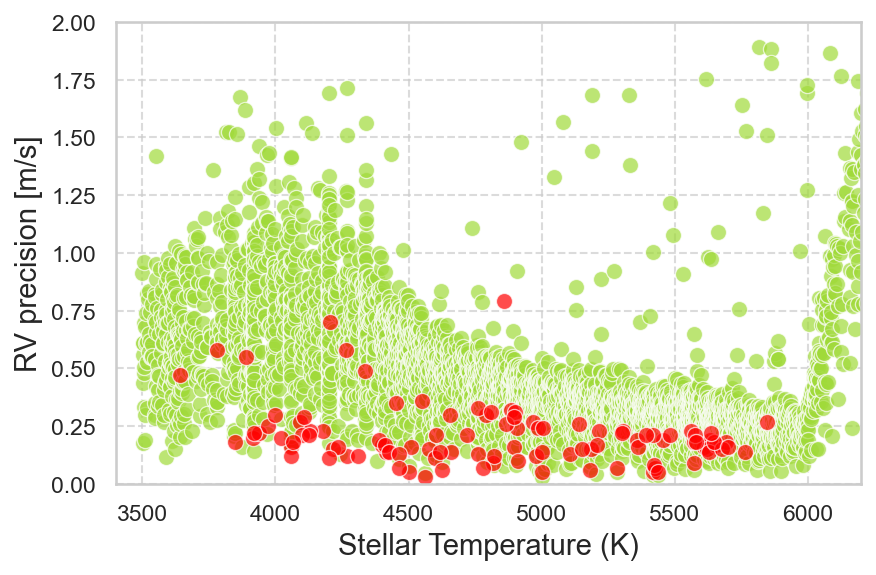

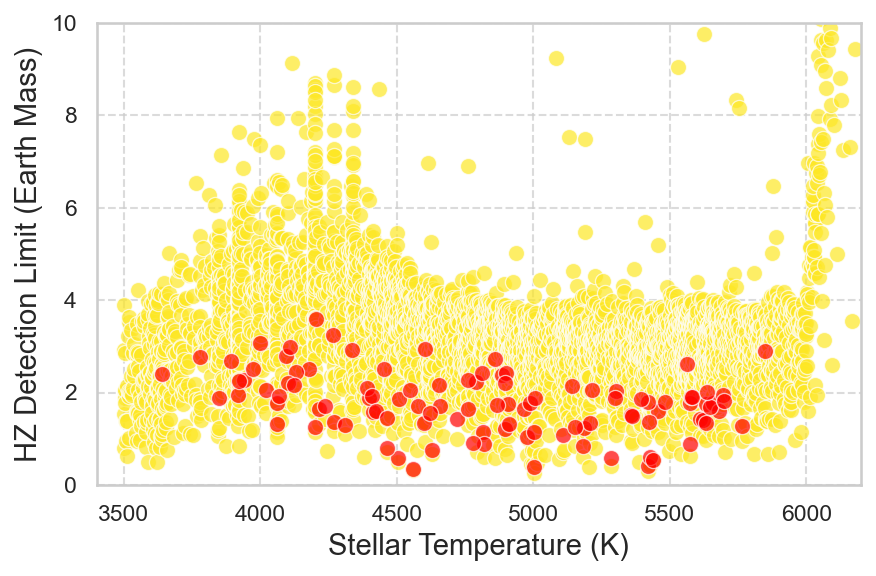

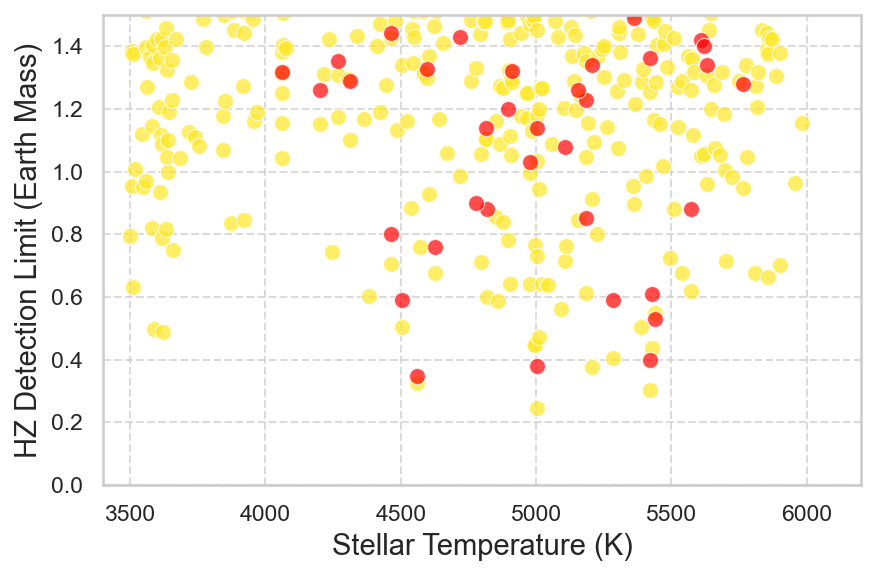

In [61]:
i = len(columns) -1

# Use the function to create the plot
plot_scatter(
    x='T_eff [K]',
    y='RV precision [m/s]',
    data=merged_df,
    xlabel='Stellar Temperature (K)',
    ylabel='RV precision [m/s]',
    xlim=(min(merged_df['T_eff [K]']) - 100, 6000 + 200),
    ylim=(0, 2),
    filename='../figures/RV_precision_vs_temperature.png',
    color=colors[i-1],  # Assuming 'colors' is defined and 'i' is an integer index
    x2 = 'T_eff [K]', 
    y2 = 'Reiners RV precision',
    data2 = merged_result_with_properties,
    color2 = 'red'
)

plot_scatter(
    x='T_eff [K]',
    y='HZ Detection Limit [M_Earth]',
    data=merged_df,
    xlabel='Stellar Temperature (K)',
    ylabel='HZ Detection Limit (M_Earth)',
    xlim=(min(merged_df['T_eff [K]']) - 100, 6000 + 200),
    ylim=(0, 10),
    filename='../figures/HZ_detection_limit_vs_temperature_full.png',
    color=colors[i],  # Replace with actual color if using a list
    x2 = 'T_eff [K]', 
    y2 = 'Reiners HZ Me limit',
    data2 = merged_result_with_properties,
    color2 = 'red'
)

plot_scatter(
    x='T_eff [K]',
    y='HZ Detection Limit [M_Earth]',
    data=merged_df,
    xlabel='Stellar Temperature (K)',
    ylabel='HZ Detection Limit (M_Earth)',
    xlim=(min(merged_df['T_eff [K]']) - 100, 6000 + 200),
    ylim=(0, 1.5),
    filename='../figures/HZ_detection_limit_vs_temperature_zoomed.png',
    color=colors[i],  # Replace with actual color if using a list
    x2 = 'T_eff [K]', 
    y2 = 'Reiners HZ Me limit',
    data2 = merged_result_with_properties,
    color2 = 'red'
)


In [62]:
print("merged_df:")
print("Number of rows in merged_df:", len(merged_df))
print("Number of rows in merged_df with HZ Detection Limit [M_Earth] < 4:", len(merged_df[merged_df['HZ Detection Limit [M_Earth]'] < 4]))
print("Number of rows in merged_df with HZ Detection Limit [M_Earth] < 1.5:", len(merged_df[merged_df['HZ Detection Limit [M_Earth]'] < 1.5]))

print("\nmerged_result_with_properties:")
print("Number of rows in merged_result_with_properties:", len(merged_result_with_properties))
print("Number of rows in merged_result_with_properties with Reiners HZ Me limit < 4:", len(merged_result_with_properties[merged_result_with_properties['Reiners HZ Me limit'] < 4]))
print("Number of rows in merged_result_with_properties with Reiners HZ Me limit < 1.5:", len(merged_result_with_properties[merged_result_with_properties['Reiners HZ Me limit'] < 1.5]))

merged_df:
Number of rows in merged_df: 4509
Number of rows in merged_df with HZ Detection Limit [Earth Mass] < 4: 3468
Number of rows in merged_df with HZ Detection Limit [Earth Mass] < 1.5: 263

merged_result_with_properties:
Number of rows in merged_result_with_properties: 107
Number of rows in merged_result_with_properties with Reiners HZ Me limit < 4: 107
Number of rows in merged_result_with_properties with Reiners HZ Me limit < 1.5: 37


In [46]:
if 0:
    merged_result = df_Melissa.merge(merged_df, left_on="Gaia name", right_on="source_id", how="inner", suffixes=('_M', '_J'))
    filename = directory + 'merged_result_MJ.xlsx'
    merged_result.to_excel(filename, index=False)
    adjust_column_widths(filename)

    len(merged_result)

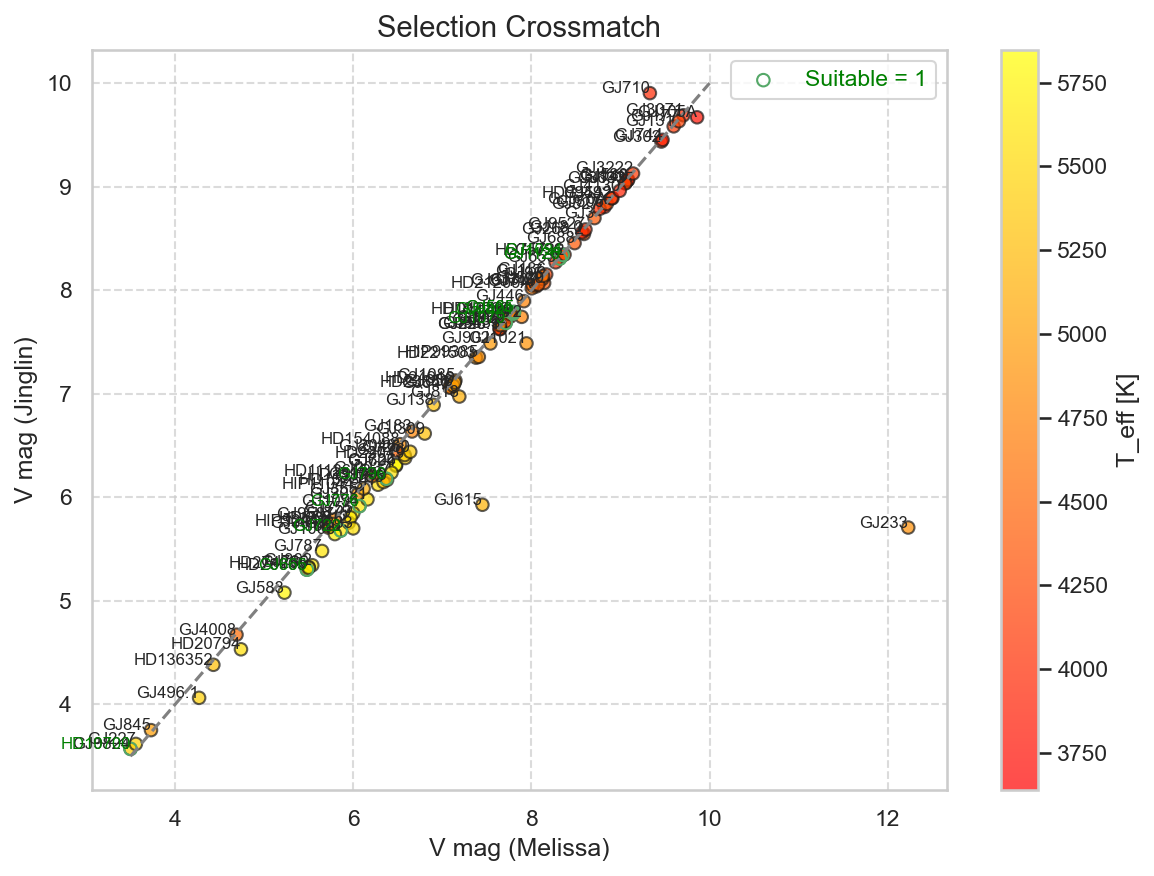

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot with color mapping
plt.figure(figsize=(8, 6), dpi=150)
scatter = plt.scatter(
    merged_result['Vmag'], 
    merged_result['V_mag'], 
    c=merged_result['T_eff [K]'], 
    cmap='autumn', 
    edgecolor='k', 
    alpha=0.7
)

# Add labels to each point
for i, name in enumerate(merged_result['other name']):
    plt.text(merged_result['Vmag'][i], merged_result['V_mag'][i], name, fontsize=8, ha='right')

# Add titles and labels
plt.title('Selection Crossmatch', fontsize=14)
plt.xlabel('V mag (Melissa)', fontsize=12)
plt.ylabel('V mag (Jinglin)', fontsize=12)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('T_eff [K]', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Overplot the suitable points from df_Melissa
suitable_indices = df_Melissa['suitable'] == 1
name_suitable = df_Melissa.loc[suitable_indices, 'other name']

x_suitable = []
y_suitable = []

for name in name_suitable:
    x_value = df_Melissa.loc[df_Melissa['other name'] == name, 'Vmag'].values[0]
    if name in merged_result['other name'].values:        
        y_value = merged_result.loc[merged_result['other name'] == name, 'V_mag'].values[0]
    else:
        y_value = 0
    x_suitable.append(x_value)
    y_suitable.append(y_value)

    plt.text(x_value, y_value, name, fontsize=8, ha='right', color='green')

# Plot the suitable points
plt.scatter(x_suitable, y_suitable, edgecolor='g', facecolors='none', label='Suitable = 1')

# Plot the x = y line
min_value = min(min(merged_result['Vmag']), min(merged_result['V_mag']))
max_value = 10
plt.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', )

# Add legend
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('green')

# Show the plot
plt.tight_layout()
plt.show()


In [48]:
# 6721432232656218752	6721432232656219136	273,0899282	-43,44664533	7,843331814	8,609505653	7,023746014	1,58575964	75,74537047	4235.4004	0.66545904	0.13317624	0.6776436	K				
# 	               6721432232656218752	273,0899538	-43,44670336	7,846924782	8,58617115	7,012911797	1,573259354	75,71222519	4235.4004	0.66545904	0.13317624	0.6776436	K	HD 166348	GJ 707	HIP 89211	HighPM*


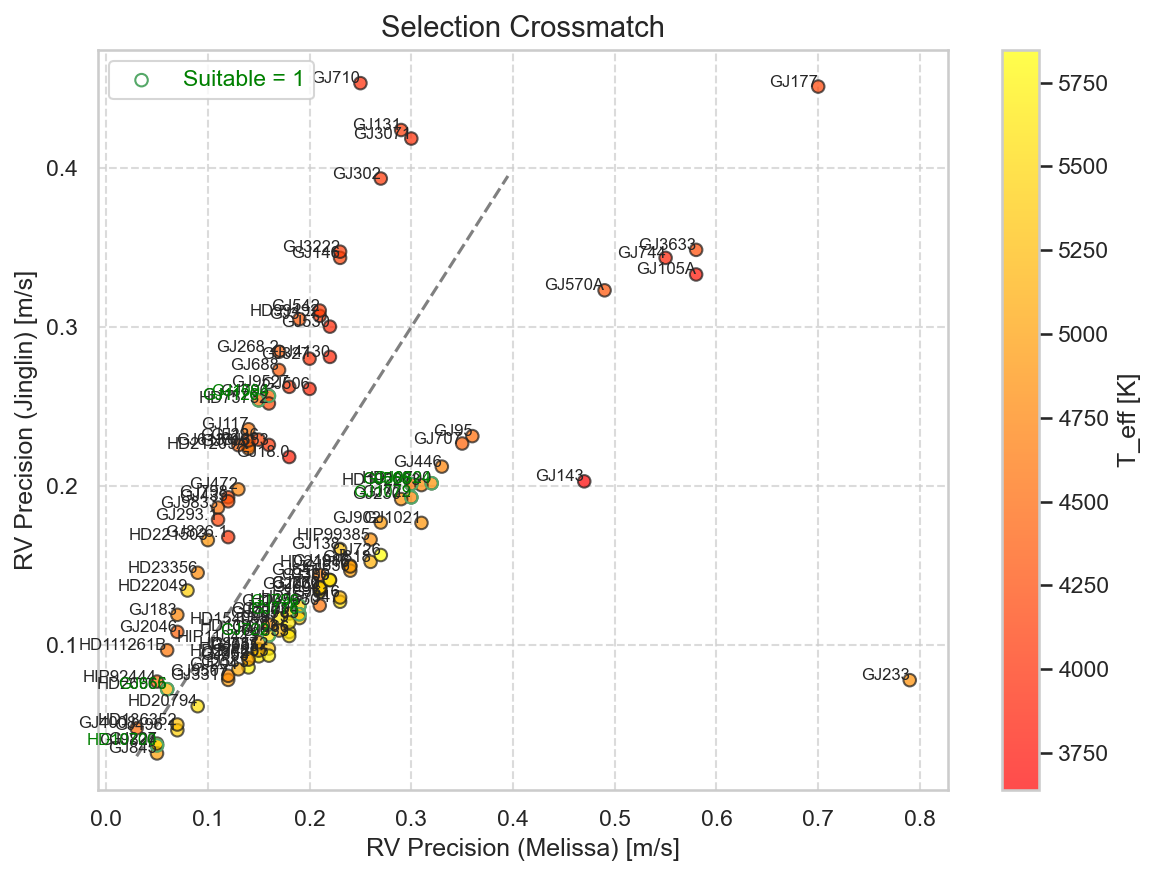

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot with color mapping
plt.figure(figsize=(8, 6), dpi=150)
scatter = plt.scatter(
    merged_result['Reiners RV precision'], 
    merged_result['RV precision [m/s]'], 
    c=merged_result['T_eff [K]'], 
    cmap='autumn', 
    edgecolor='k', 
    alpha=0.7
)

# Add labels to each point
for i, name in enumerate(merged_result['other name']):
    plt.text(merged_result['Reiners RV precision'][i], merged_result['RV precision [m/s]'][i], name, fontsize=8, ha='right')

# Add titles and labels
plt.title('Selection Crossmatch', fontsize=14)
plt.xlabel('RV Precision (Melissa) [m/s]', fontsize=12)
plt.ylabel('RV Precision (Jinglin) [m/s]', fontsize=12)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('T_eff [K]', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Overplot the suitable points from df_Melissa
suitable_indices = df_Melissa['suitable'] == 1
name_suitable = df_Melissa.loc[suitable_indices, 'other name']

x_suitable = []
y_suitable = []

for name in name_suitable:
    x_value = df_Melissa.loc[df_Melissa['other name'] == name, 'Reiners RV precision'].values[0]
    if name in merged_result['other name'].values:        
        y_value = merged_result.loc[merged_result['other name'] == name, 'RV precision [m/s]'].values[0]
    else:
        y_value = 0
    x_suitable.append(x_value)
    y_suitable.append(y_value)

    # name = df_Melissa.loc[df_Melissa['Reiners RV precision'] == x, 'other name'].values[0]
    plt.text(x_value, y_value, name, fontsize=8, ha='right', color='green')

# Plot the suitable points
plt.scatter(x_suitable, y_suitable, edgecolor='g', facecolors='none', label='Suitable = 1')

# Plot the x = y line
min_value = min(min(merged_result['Reiners RV precision']), min(merged_result['RV precision [m/s]']))
max_value = max(max(merged_result['Reiners RV precision'])*0.5, max(merged_result['RV precision [m/s]'])*0.5)
plt.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', )

# Add legend
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('green')

# Show the plot
plt.tight_layout()
plt.savefig('../figures/RV_precision_comparison.png')
plt.show()


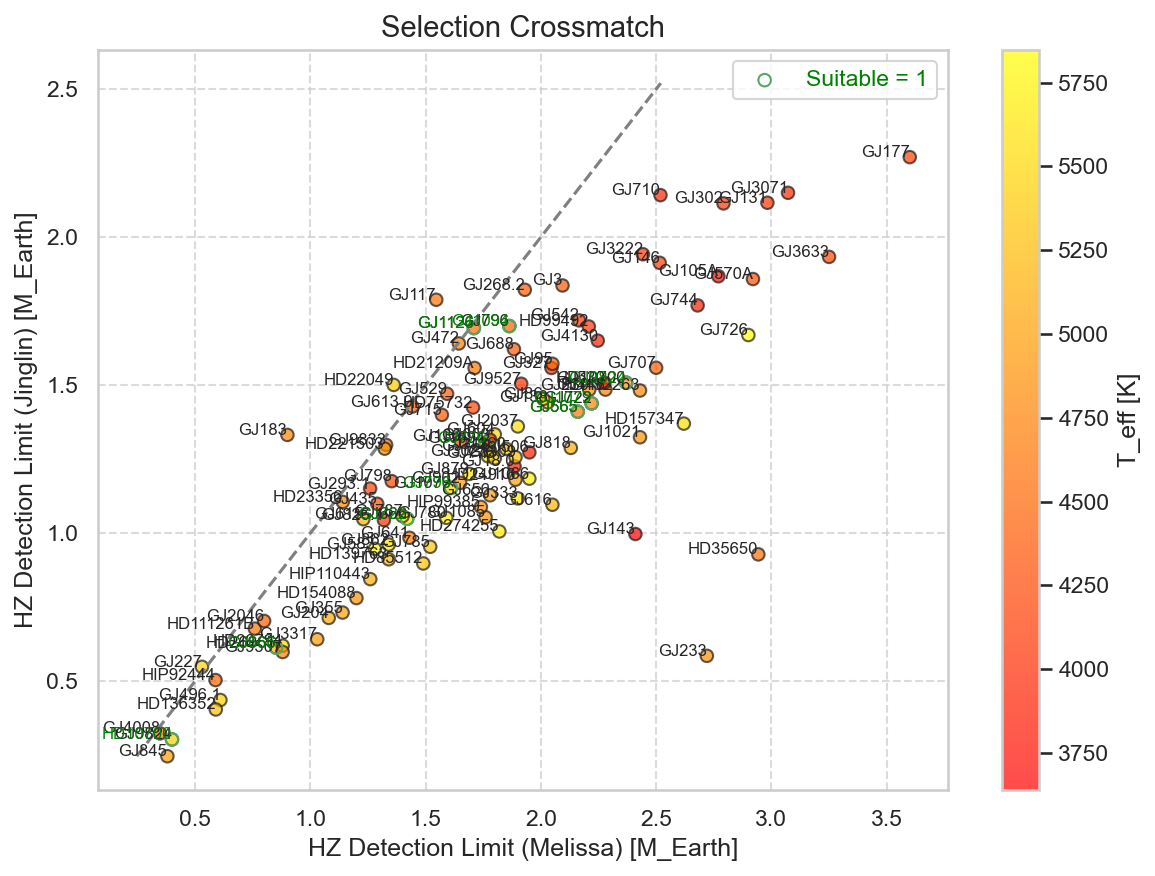

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot with color mapping
plt.figure(figsize=(8, 6), dpi=150)
scatter = plt.scatter(
    merged_result['Reiners HZ Me limit'], 
    merged_result['HZ Detection Limit [M_Earth]'], 
    c=merged_result['T_eff [K]'], 
    cmap='autumn', 
    edgecolor='k', 
    alpha=0.7
)

# Add labels to each point
for i, name in enumerate(merged_result['other name']):
    plt.text(merged_result['Reiners HZ Me limit'][i], merged_result['HZ Detection Limit [M_Earth]'][i], name, fontsize=8, ha='right')

# Add titles and labels
plt.title('Selection Crossmatch', fontsize=14)
plt.xlabel('HZ Detection Limit (Melissa) [M_Earth]', fontsize=12)
plt.ylabel('HZ Detection Limit (Jinglin) [M_Earth]', fontsize=12)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('T_eff [K]', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Overplot the suitable points from df_Melissa
suitable_indices = df_Melissa['suitable'] == 1
name_suitable = df_Melissa.loc[suitable_indices, 'other name']

x_suitable = []
y_suitable = []

for name in name_suitable:
    x_value = df_Melissa.loc[df_Melissa['other name'] == name, 'Reiners HZ Me limit'].values[0]
    if name in merged_result['other name'].values:        
        y_value = merged_result.loc[merged_result['other name'] == name, 'HZ Detection Limit [M_Earth]'].values[0]
    else:
        y_value = 0
    x_suitable.append(x_value)
    y_suitable.append(y_value)

    # Add red labels for suitable points
    plt.text(x_value, y_value, name, fontsize=8, ha='right', color='green')

# Plot the suitable points
plt.scatter(x_suitable, y_suitable, edgecolor='g', facecolors='none', label='Suitable = 1')

# Plot the x = y line
min_value = min(min(merged_result['Reiners HZ Me limit']), min(merged_result['HZ Detection Limit [M_Earth]']))
max_value = max(max(merged_result['Reiners HZ Me limit'])*0.7, max(merged_result['HZ Detection Limit [M_Earth]'])*0.7)
plt.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', )

# Add legend
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('green')

# Show the plot
plt.tight_layout()
plt.savefig('../figures/HZ_detection_limit_comparison.png')
plt.show()



# Others

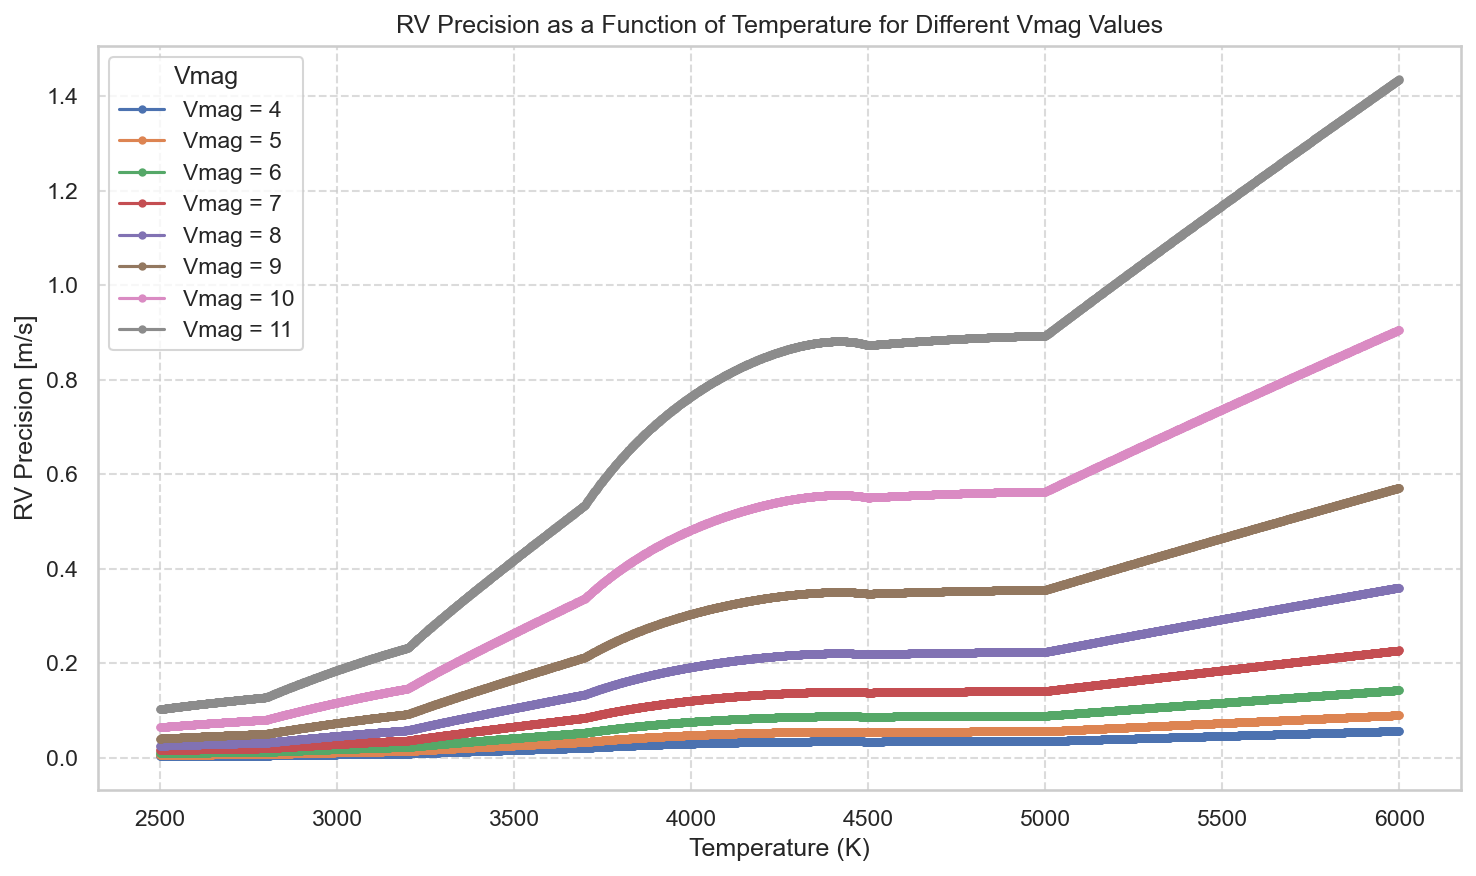

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Define temperature and Vmag ranges
temperatures = np.arange(2500, 6000, 1)
vmags = np.arange(4, 12, 1)

# Store RV precision results
rv_precision_results = {vmag: [] for vmag in vmags}

# Calculate RV precision for each combination of temperature and Vmag
for temperature in temperatures:
    for vmag in vmags:
        result, rv_precision = calculate_rv_precision(Temp=temperature, Vmag=vmag)
        rv_precision_results[vmag].append(rv_precision)

# Plotting
plt.figure(figsize=(10, 6), dpi=150)
for vmag, rv_precisions in rv_precision_results.items():
    plt.plot(temperatures, rv_precisions, label=f'Vmag = {vmag}', marker='.')

# Add titles and labels
plt.title('RV Precision as a Function of Temperature for Different Vmag Values')
plt.xlabel('Temperature (K)')
plt.ylabel('RV Precision [m/s]')
plt.legend(title='Vmag')
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [52]:
from astroquery.vizier import Vizier
import pandas as pd

# Initialize Vizier with a row limit, you can adjust this as needed
Vizier.ROW_LIMIT = 100  # Set to -1 for no limit

# Define the catalog you want to query
catalog = "V/137D"  # This is an example catalog, you might need to adjust based on your needs

# Define the columns you are interested in
columns = ['Teff', 'Mass', 'Radius', 'Vmag']

# Perform the query
result = Vizier(columns=columns).query_constraints(catalog=catalog)

# Check if any results were returned
if result:
    # Convert the result to a pandas DataFrame
    df = result[0].to_pandas()
    
    # Display the first few rows of the DataFrame
    print(df.head())
else:
    print("No data found for the specified query.")

   Vmag
0  9.10
1  9.27
2  6.61
3  8.06
4  8.55


In [53]:
from astroquery.vizier import Vizier
import pandas as pd

# Initialize Vizier with a row limit
Vizier.ROW_LIMIT = 1  # Since we're looking for a specific star

# Example catalog: Hipparcos catalog
catalog = "I/239/hip_main"  # Hipparcos Main Catalogue

# Define the object name
star_name = "HD 10700"

# Perform the query
result = Vizier.query_object(star_name, catalog=catalog)

# Check if any results were returned
if result:
    # Convert the result to a pandas DataFrame
    df = result[0].to_pandas()
    
    # Print the available columns to see what data we have
    print("Available columns:", df.columns)
    
    # Display the first few rows of the DataFrame
    display(df.head())
else:
    print("No data found for the specified query.")


Available columns: Index(['HIP', 'RAhms', 'DEdms', 'Vmag', 'RAICRS', 'DEICRS', 'Plx', 'pmRA',
       'pmDE', 'e_Plx', 'B-V', 'Notes', '_RA.icrs', '_DE.icrs'],
      dtype='object')


HIP        RAhms        DEdms  Vmag     RAICRS     DEICRS         Plx  \
0  8102  01 44 05.13  -15 56 22.4  3.49  26.021364 -15.939556  274.170013   

      pmRA    pmDE  e_Plx    B-V Notes   _RA.icrs  _DE.icrs  
0 -1721.82  854.07    0.8  0.727        26.017012 -15.93748